# Importación de librerías

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import re
import h5py
from scipy import signal
from scipy.signal import filtfilt
import pandas as pd
import pywt

## Leyendo el archivos

In [141]:
# Parámetros del BITalino ECG
fs = 1000                # Frecuencia de muestreo (Hz)
GAIN = 1100              # Ganancia del canal ECG del BITalino
VCC = 3.3                # Voltaje de referencia ADC
ADC_RES = 1024.0         # Resolución del ADC (10 bits)
OFFSET = 512             # Valor medio del ADC BITalino

def analizar_ecg(ruta, base, canal, inicio, fin):
    with h5py.File(ruta, "r") as f:
        data = f[f"{base}/{canal}"][:].squeeze()

    # --- Conversión a microvoltios (µV) ---
    centered = data.astype(np.float32) - OFFSET              # Quitar offset ADC
    volt = centered * (VCC / ADC_RES)                        # Convertir a voltios
    ecg_volt = volt / GAIN                                   # Dividir por ganancia
    microvolt = ecg_volt * 1e6                               # Pasar a microvoltios
    microvolt -= np.mean(microvolt)                          # Quitar DC residual

    # --- Eje temporal completo ---
    t = np.arange(len(microvolt)) / fs

    # --- Segmento de interés ---
    idx0, idx1 = int(inicio * fs), min(int(fin * fs), len(microvolt))
    seg = microvolt[idx0:idx1]

    # Eje temporal del segmento (reiniciado desde 0)
    t_seg = np.arange(0, len(seg)) / fs

    return seg, t_seg


In [142]:
# Uso
y_1, t_1 = analizar_ecg("Reposo - derivada 2.h5", "98:D3:81:FD:6D:86/raw", "channel_2", 5, 30)
y_2, t_2 = analizar_ecg("AR - derivada 2 -  intento 1.h5", "98:D3:81:FD:6D:86/raw", "channel_2", 15, 90)
y_3, t_3 = analizar_ecg("Correr - derivada 2.h5", "98:D3:81:FD:6D:86/raw", "channel_2",5, 50)


## A) Análisis para señal: Reposo - derivada 2

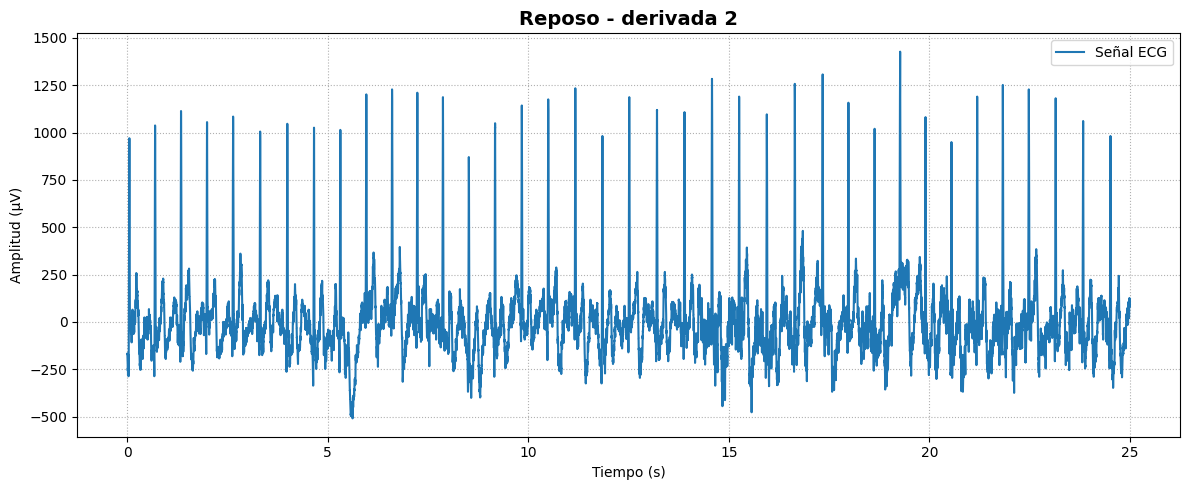

In [143]:
# --- Gráfico de la señal ECG ---
plt.figure(figsize=(12, 5))
plt.plot(t_1, y_1, label="Señal ECG")
plt.title("Reposo - derivada 2", fontsize=14, fontweight='bold', loc='center')  # centrado correctamente
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (µV)")
plt.grid(linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


## DFT

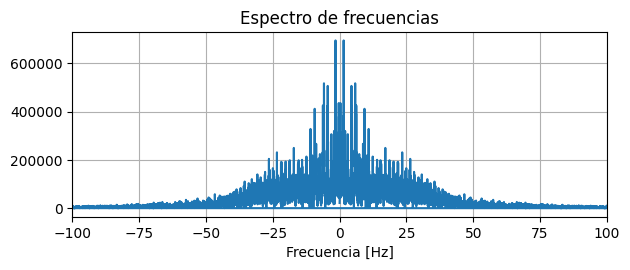

In [144]:
# Calcular la DFT
X = np.fft.fft(y_1)

# Calcular las frecuencias correspondientes
frequencies = np.fft.fftfreq(len(y_1), 1/fs)

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(X))
plt.title('Espectro de frecuencias')
plt.xlabel('Frecuencia [Hz]')
plt.grid()

# Establecer límites en el eje x
plt.xlim([-100, 100])

plt.tight_layout()
plt.show()

## STFT

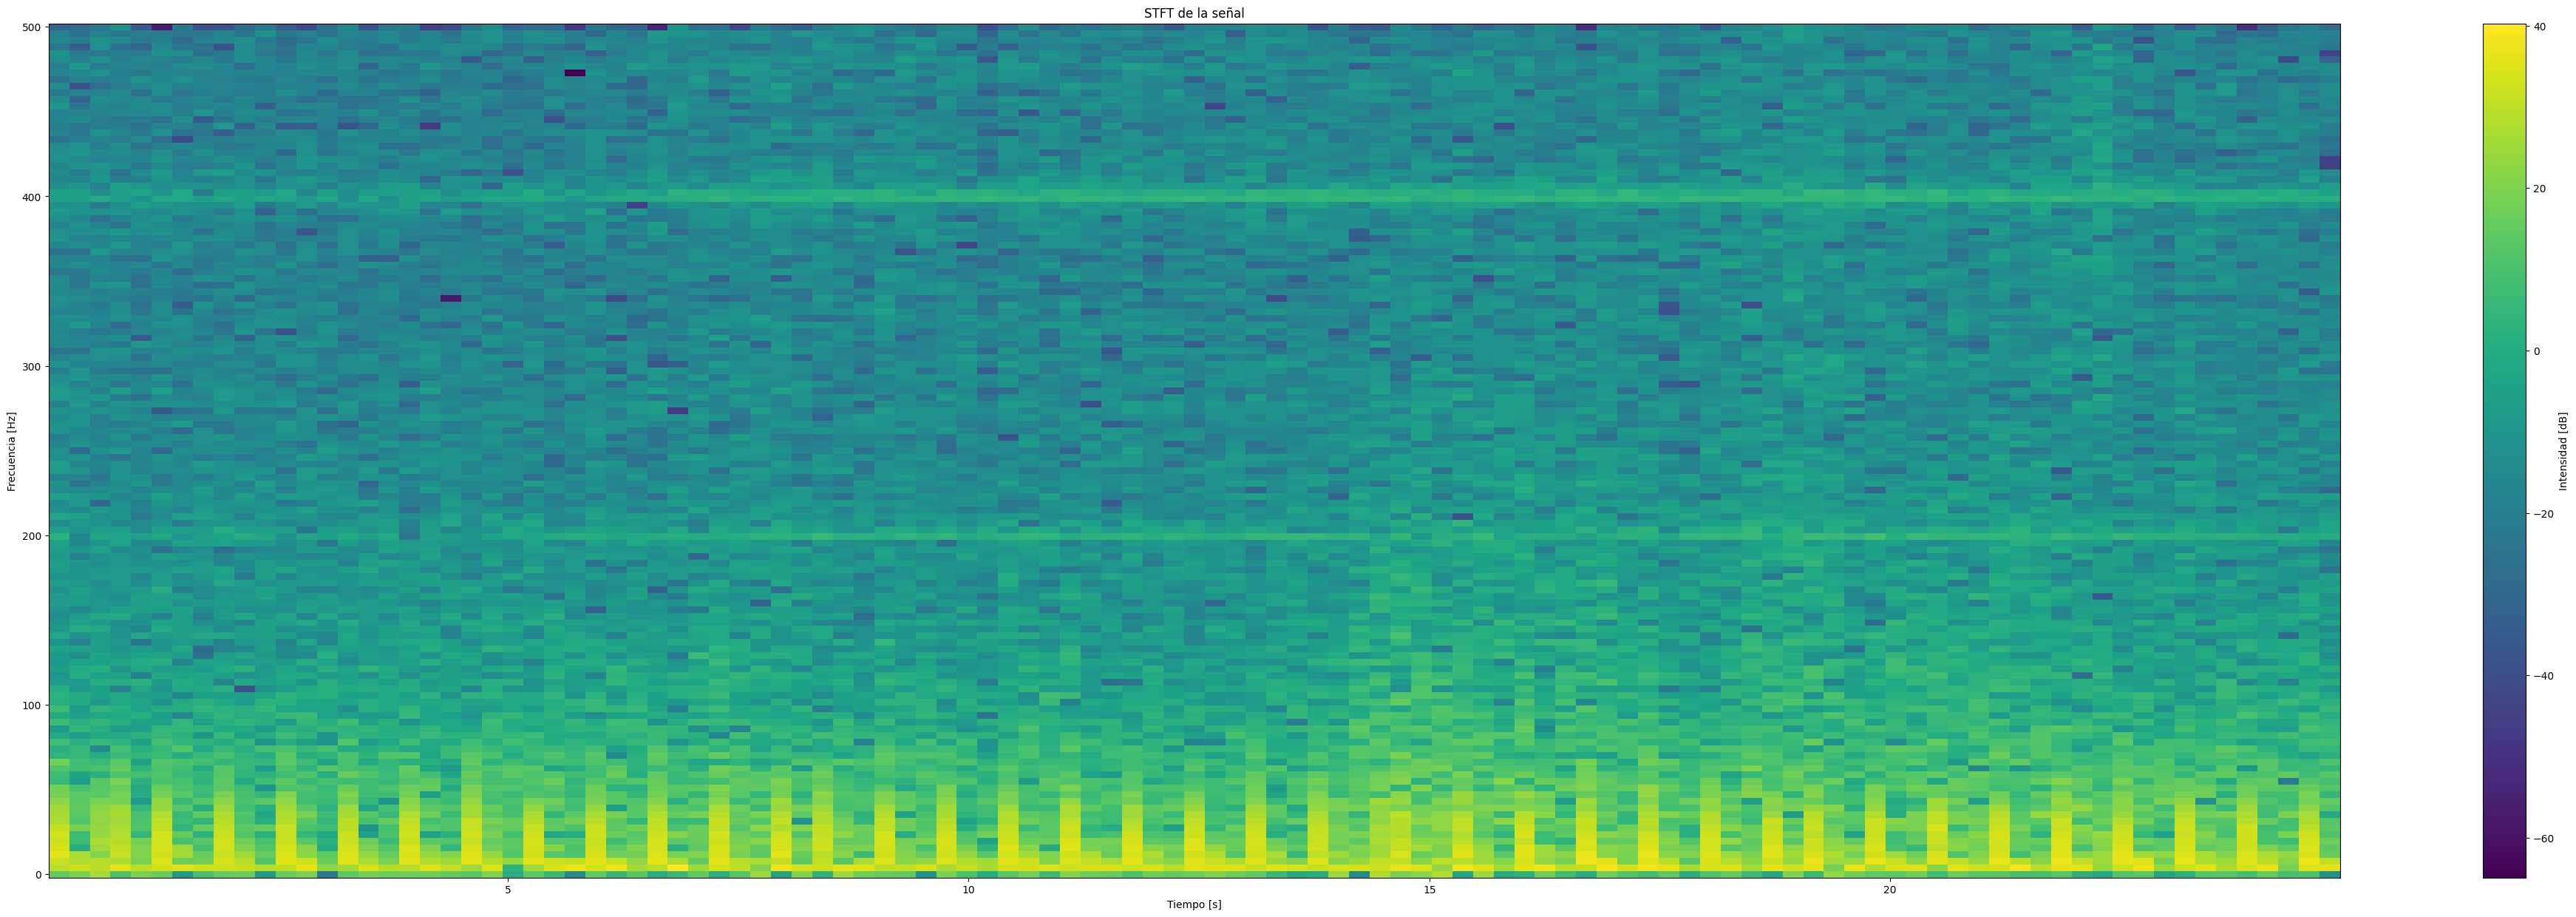

In [145]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Calcular la STFT
f, t, Sxx = spectrogram(y_1, fs)
plt.figure(figsize=(50, 15))

# Visualizar el espectrograma
plt.pcolormesh(t, f, 10 * np.log10(Sxx))  # Usamos escala logarítmica para mejor visualización
plt.title('STFT de la señal')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.colorbar(label='Intensidad [dB]')
plt.show()


# Transformada de Wavelet Continua (CWT)

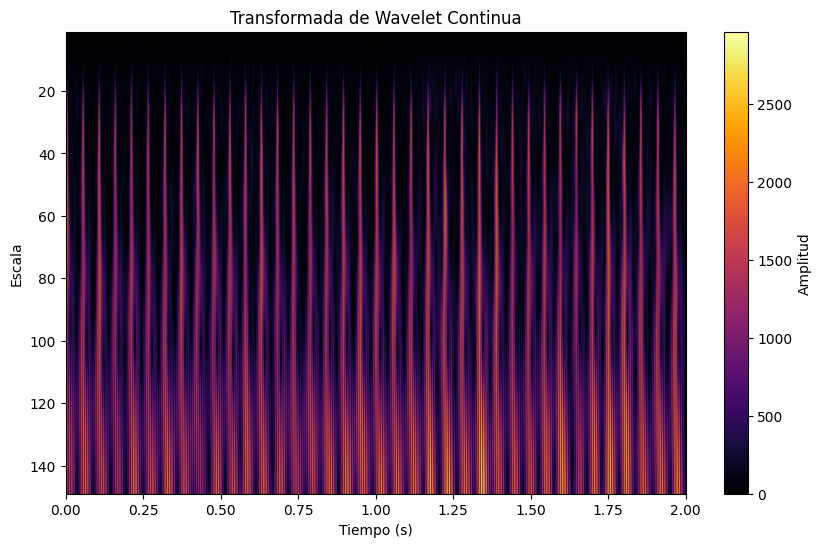

¿coinciden frecuencias?  True


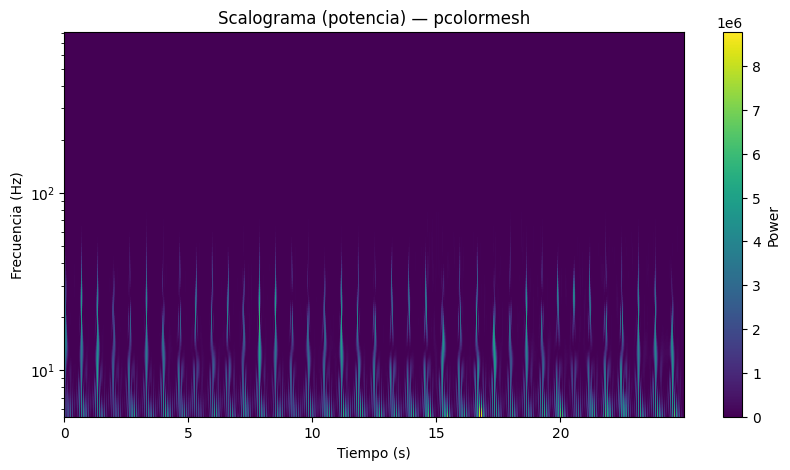

In [146]:
import pywt

# Definir la escala y la frecuencia central de la wavelet de Morlet
escala = np.arange(1, 150)

# Realizar la transformada de wavelet continua
coeficientes, frecuencias = pywt.cwt(y_1, escala, 'morl',sampling_period=1/1000)

# Graficar los coeficientes de la transformada de wavelet
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeficientes), extent=[0, 2, escala[-1], escala[0]], aspect='auto', cmap='inferno')
plt.colorbar(label='Amplitud')
plt.title('Transformada de Wavelet Continua')
plt.xlabel('Tiempo (s)')
plt.ylabel('Escala')
plt.show()


# verificación (opcional): calcular frecuencias con scale2frequency
freqs_check = pywt.scale2frequency('morl', escala) * fs
print("¿coinciden frecuencias? ", np.allclose(frecuencias, freqs_check))

# potencia (o magnitud), y normalización si quieres comparar escalas
power = np.abs(coeficientes)**2
# normalización común para comparar amplitudes entre escalas:
power_norm = power / np.sqrt(escala)[:, None]

# 1) Usando pcolormesh
plt.figure(figsize=(10,5))
plt.pcolormesh(t_1, frecuencias, power, shading='auto');
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.yscale('log')
plt.title('Scalograma (potencia) — pcolormesh')
plt.colorbar(label='Power')
plt.ylim(frecuencias.min(),frecuencias.max())
plt.show()



# Transformada de Wavelet Discreta (DWT)

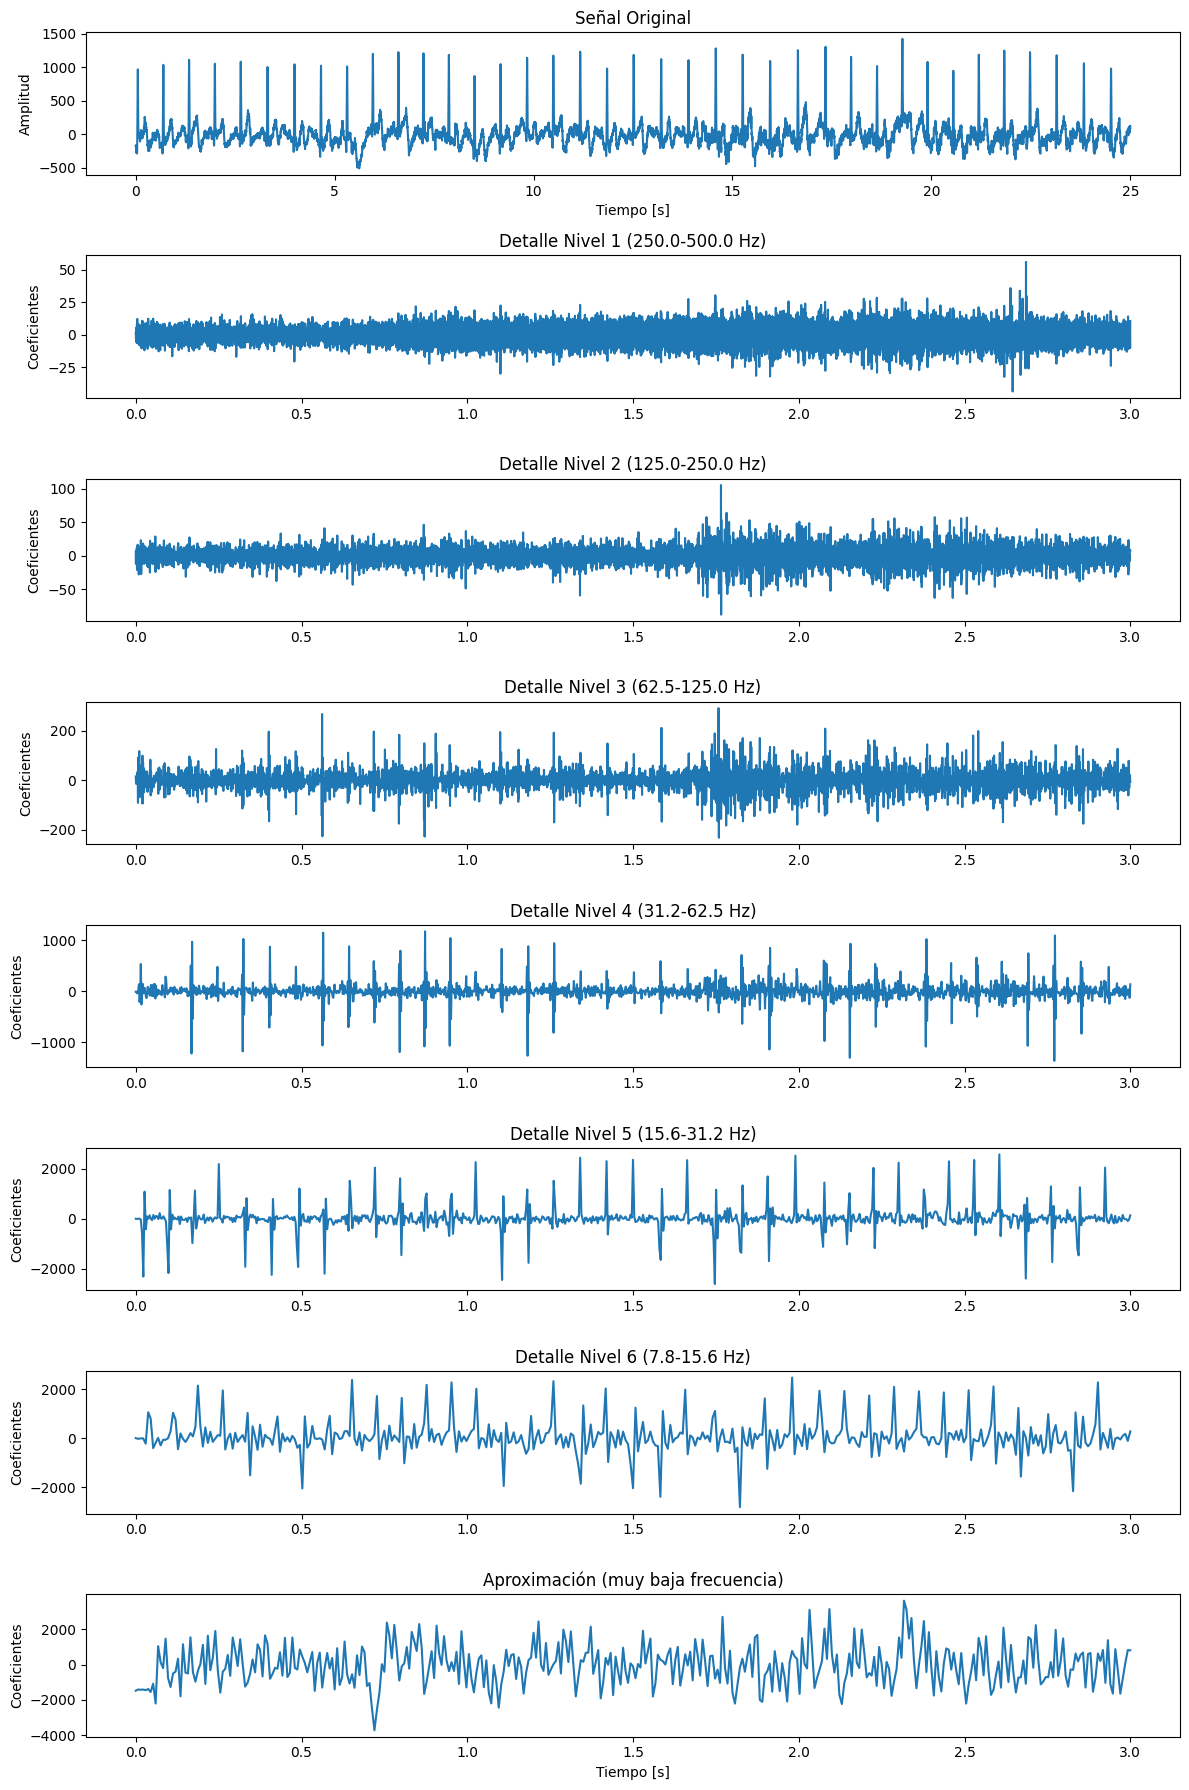

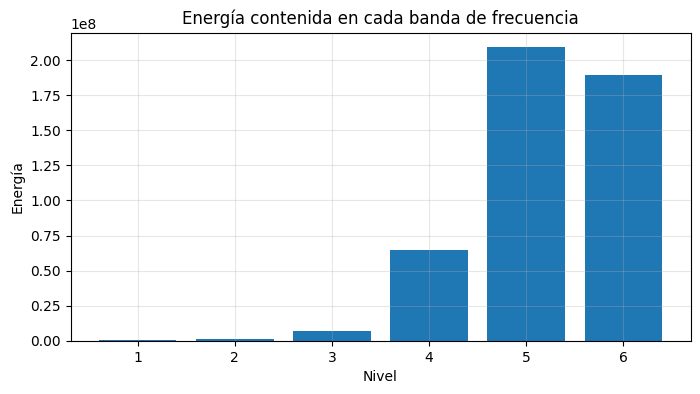

Nivel 1: 250.00 - 500.00 Hz | Energía = 683757.38
Nivel 2: 125.00 - 250.00 Hz | Energía = 1199750.25
Nivel 3: 62.50 - 125.00 Hz | Energía = 6794488.00
Nivel 4: 31.25 - 62.50 Hz | Energía = 64824424.00
Nivel 5: 15.62 - 31.25 Hz | Energía = 209147808.00
Nivel 6: 7.81 - 15.62 Hz | Energía = 189354480.00


In [147]:
# ======================================
# PARTE 1: DWT
# ======================================
wavelet = 'db6'
niveles = 6
coeficientes = pywt.wavedec(y_1, wavelet, level=niveles)

# ======================================
# PARTE 2: Análisis de energía y bandas
# ======================================
# wavedec devuelve: [cA_n, cD_n, cD_{n-1}, ..., cD_1]
detalles = coeficientes[1:][::-1]  # invertimos el orden

energias = [np.sum(np.square(c)) for c in detalles]

# Bandas de frecuencia aproximadas para cada nivel
bandas = [(fs / (2 ** (i + 1)), fs / (2 ** i)) for i in range(1, niveles + 1)]

# ======================================
# PARTE 3: Gráficas
# ======================================
plt.figure(figsize=(12, 18))
plt.subplot(niveles + 2, 1, 1)
plt.plot(t_1, y_1)
plt.title('Señal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

# Graficar los niveles 1 → n (altas → bajas)
for i, c in enumerate(detalles, start=1):
    t_c = np.linspace(0, 3, len(c))  # eje temporal aproximado
    plt.subplot(niveles + 2, 1, i + 1)
    plt.plot(t_c, c)
    plt.title(f'Detalle Nivel {i} ({bandas[i-1][0]:.1f}-{bandas[i-1][1]:.1f} Hz)')
    plt.ylabel('Coeficientes')

# Aproximación final (muy baja frecuencia)
t_a = np.linspace(0, 3, len(coeficientes[0]))
plt.subplot(niveles + 2, 1, niveles + 2)
plt.plot(t_a, coeficientes[0])
plt.title('Aproximación (muy baja frecuencia)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Coeficientes')

plt.tight_layout()
plt.show()

# ======================================
# PARTE 4: Energía por nivel
# ======================================
plt.figure(figsize=(8, 4))
niveles_list = np.arange(1, niveles + 1)
plt.bar(niveles_list, energias)
plt.xlabel('Nivel')
plt.ylabel('Energía')
plt.title('Energía contenida en cada banda de frecuencia')
plt.xticks(niveles_list)
plt.grid(True, alpha=0.3)
plt.show()

# Mostrar tabla resumen
for i, (f_low, f_high) in enumerate(bandas):
    print(f"Nivel {i+1}: {f_low:.2f} - {f_high:.2f} Hz | Energía = {energias[i]:.2f}")



## Filtrar señal con Wavelet (db6)

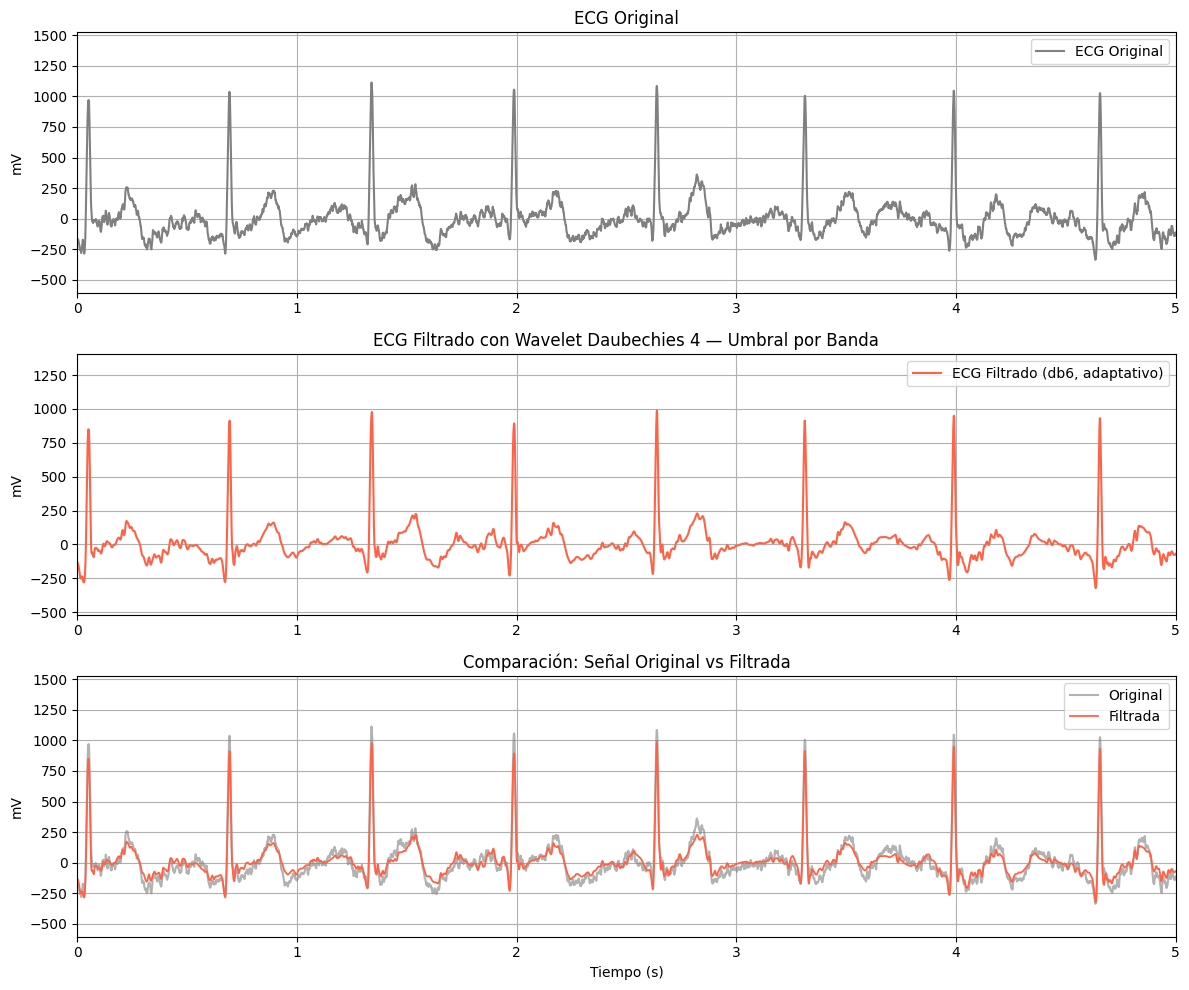

In [148]:
# --- Descomposición en wavelets ---
wavelet = 'db6'      # Wavelet más suave, buena para ECG
nivel = 6
coeffs = pywt.wavedec(y_1, wavelet, level=nivel)

# --- Frecuencia de muestreo ---
fs = 1000

# --- Calcular umbrales adaptativos ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))
        T *= 0.1
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

    else:
        # Detalles: ruido o componentes rápidas
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # En ECG, queremos conservar 0.5–40 Hz aprox
        if i == 1:      # D6 (~0–8 Hz)
            T *= 0.1   # Suavizar leve: respiración o línea base
        elif i == 2:    # D5 (~8–16 Hz)
            T *=0.1  # Mantener componentes útiles (onda T)
        elif i == 3:    # D4 (~16–32 Hz)
            T *=0.1  # Mantener QRS
        elif i == 4:    # D3 (~32–64 Hz)
            T *= 1.1  # Mantener QRS agudo
        elif i == 5:    # D2 (~64–128 Hz)
            T *= 1.8  # Ruido muscular o eléctrico
        elif i == 6:    # D1 (>128 Hz)
            T *= 2   # Filtrar agresivamente (ruido electromagnético
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

# --- Reconstrucción de la señal filtrada ---
senal_denoised = pywt.waverec(coeffs_umbral, wavelet)

# --- Gráficas ---
plt.figure(figsize=(12, 10))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(t_1, y_1, color='gray', label='ECG Original')
plt.title('ECG Original')
plt.ylabel('mV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# Señal filtrada
plt.subplot(3, 1, 2)
plt.plot(t_1, senal_denoised, color='tomato', label='ECG Filtrado (db6, adaptativo)')
plt.title('ECG Filtrado con Wavelet Daubechies 4 — Umbral por Banda')
plt.xlim(0,5)
plt.ylabel('mV')
plt.grid(True)
plt.legend()

# Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_1, y_1, color='gray', alpha=0.6, label='Original')
plt.plot(t_1, senal_denoised, color='tomato', linewidth=1.3, label='Filtrada')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlim(0,5)
plt.xlabel('Tiempo (s)')
plt.ylabel('mV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



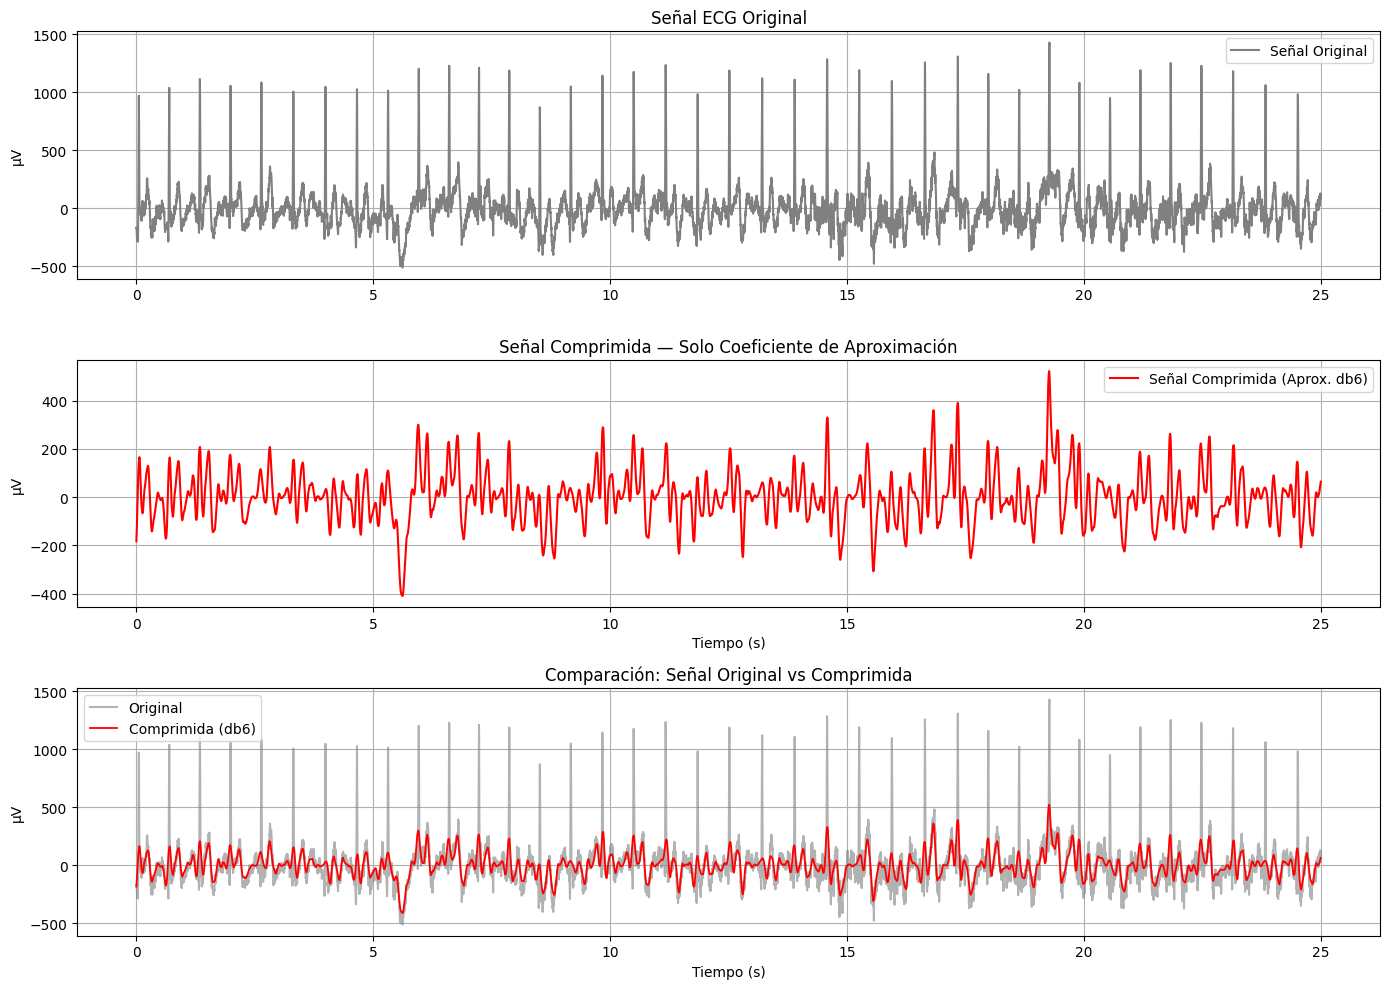

In [149]:
# Obtener los coeficientes de aproximación
coef_aproximacion = coeffs_umbral[0]

coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion

# Reconstruir la señal comprimida
senal_comprimida = pywt.waverec(coeffs_zero, 'db6')

# Obtener el tiempo correspondiente a los datos
t_1_2 = np.linspace(0, len(y_1)/1000, len(senal_comprimida))


# --- Graficar ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_1, y_1, label='Señal Original', color='gray')
plt.title('Señal ECG Original')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_1_2, senal_comprimida, label='Señal Comprimida (Aprox. db6)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación')
plt.ylabel('µV')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_1, y_1, color='gray', alpha=0.6, label='Original')
plt.plot(t_1_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (db6)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Filtrar señal con Wavelet (sym4)

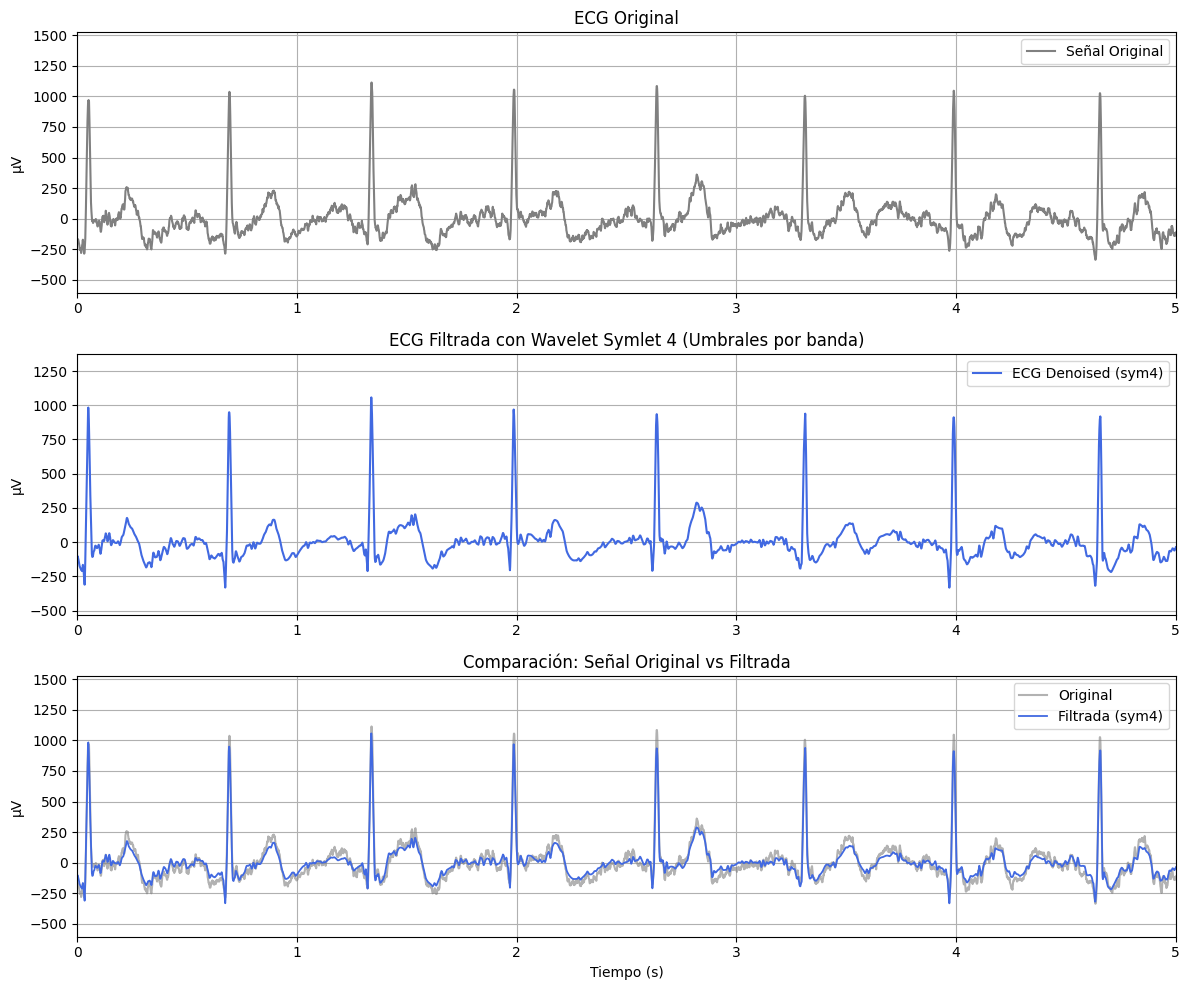

In [150]:
# --- Descomposición wavelet ---
coeffs = pywt.wavedec(y_1, 'sym4', level=6)

# Mantener la aproximación (bajas frecuencias)
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))
        T *= 0.08
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

    else:
        # Detalles: ruido o componentes rápidas
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # En ECG, queremos conservar 0.5–40 Hz aprox
        if i == 1:      # D6 (~0–8 Hz)
            T *= 0.1   # Suavizar leve: respiración o línea base
        elif i == 2:    # D5 (~8–16 Hz)
            T *=0.1  # Mantener componentes útiles (onda T)
        elif i == 3:    # D4 (~16–32 Hz)
            T *=0.1  # Mantener QRS
        elif i == 4:    # D3 (~32–64 Hz)
            T *= 1.1  # Mantener QRS agudo
        elif i == 5:    # D2 (~64–128 Hz)
            T *= 1.8  # Ruido muscular o eléctrico
        elif i == 6:    # D1 (>128 Hz)
            T *= 2   # Filtrar agresivamente (ruido electromagnético
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))


# --- Reconstrucción ---
senal_denoised = pywt.waverec(coeffs_umbral, 'sym4')
senal_denoised = senal_denoised[:len(y_1)]  # ajustar tamaño

# --- Gráficas ---
plt.figure(figsize=(12, 10))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(t_1, y_1, color='gray', label='Señal Original')
plt.title('ECG Original')
plt.xlim(0,5)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# Señal denoised
plt.subplot(3, 1, 2)
plt.plot(t_1, senal_denoised, color='royalblue', label='ECG Denoised (sym4)')
plt.title('ECG Filtrada con Wavelet Symlet 4 (Umbrales por banda)')
plt.xlim(0,5)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_1, y_1, color='gray', alpha=0.6, label='Original')
plt.plot(t_1, senal_denoised, color='royalblue', linewidth=1.3, label='Filtrada (sym4)')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlim(0,5)
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


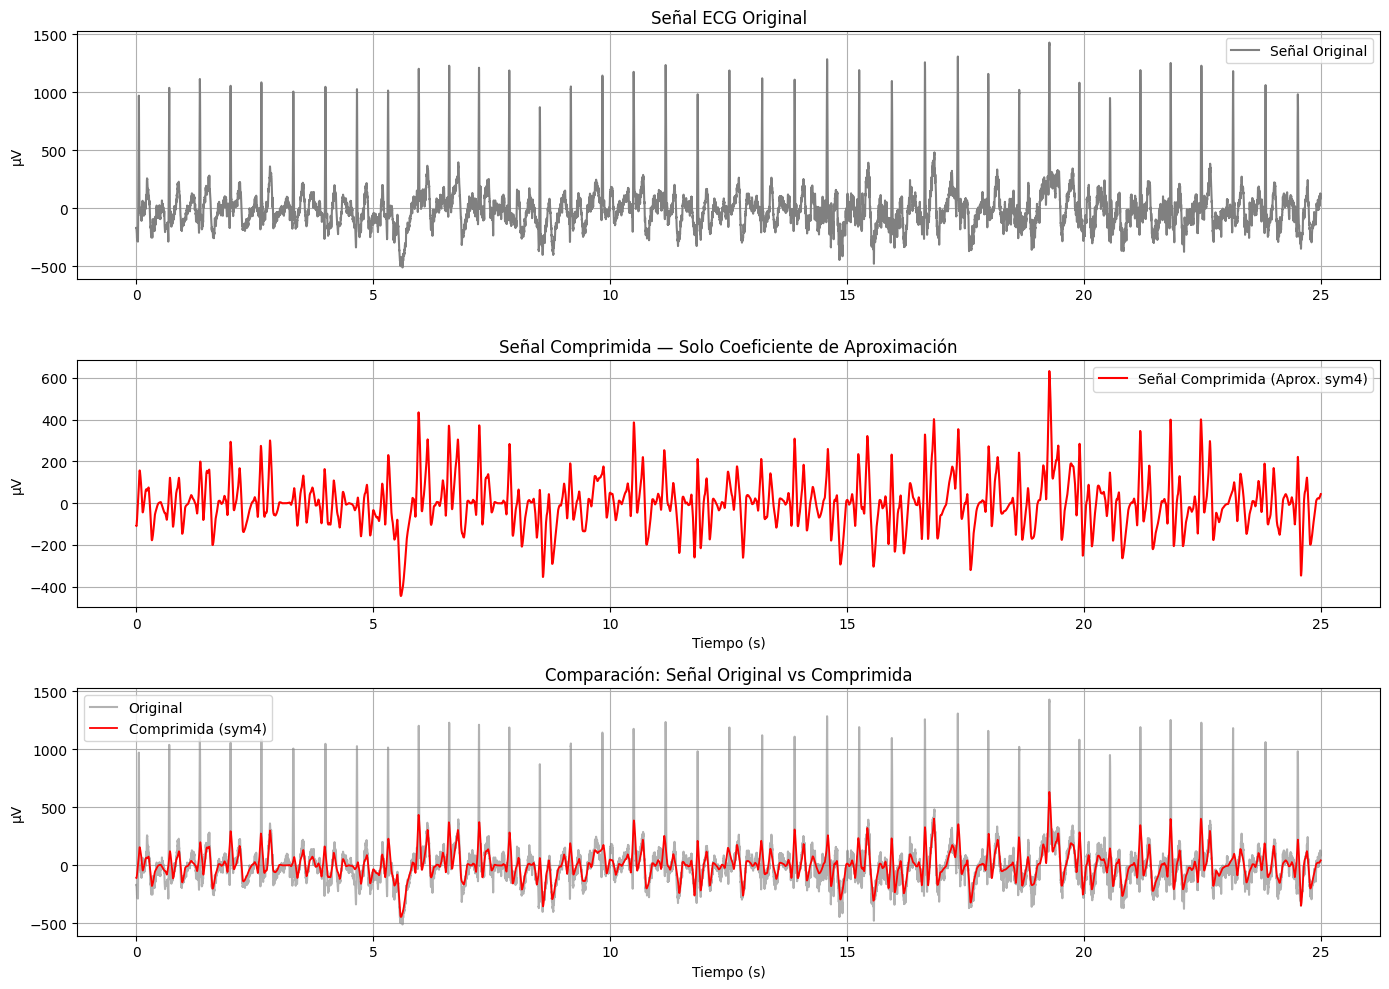

In [151]:
# Obtener los coeficientes de aproximación
coef_aproximacion = coeffs_umbral[0]

coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion

# Reconstruir la señal comprimida
senal_comprimida = pywt.waverec(coeffs_zero, 'sym4')

# Obtener el tiempo correspondiente a los datos
t_1_2 = np.linspace(0, len(y_1)/1000, len(senal_comprimida))


# --- Graficar ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_1, y_1, label='Señal Original', color='gray')
plt.title('Señal ECG Original')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_1_2, senal_comprimida, label='Señal Comprimida (Aprox. sym4)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación')
plt.ylabel('µV')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_1, y_1, color='gray', alpha=0.6, label='Original')
plt.plot(t_1_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (sym4)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## B) Análisis para señal: Apnea respiratoria - derivada 2

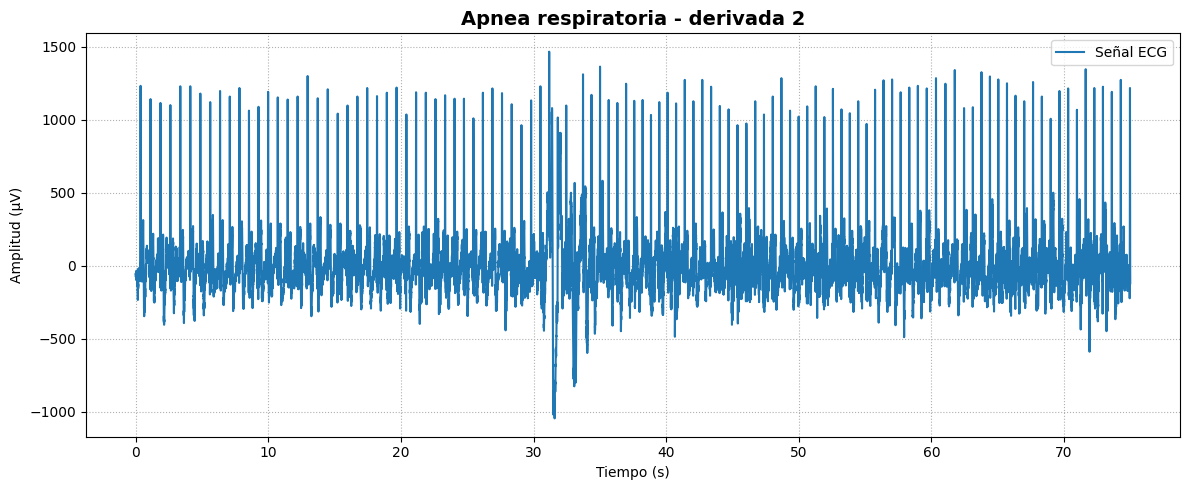

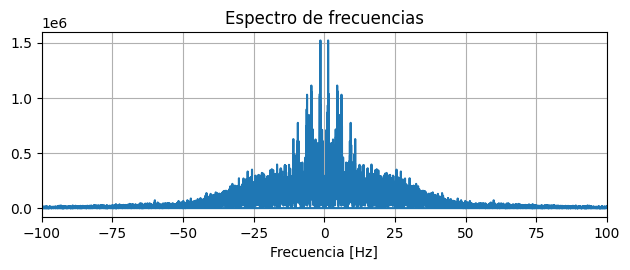

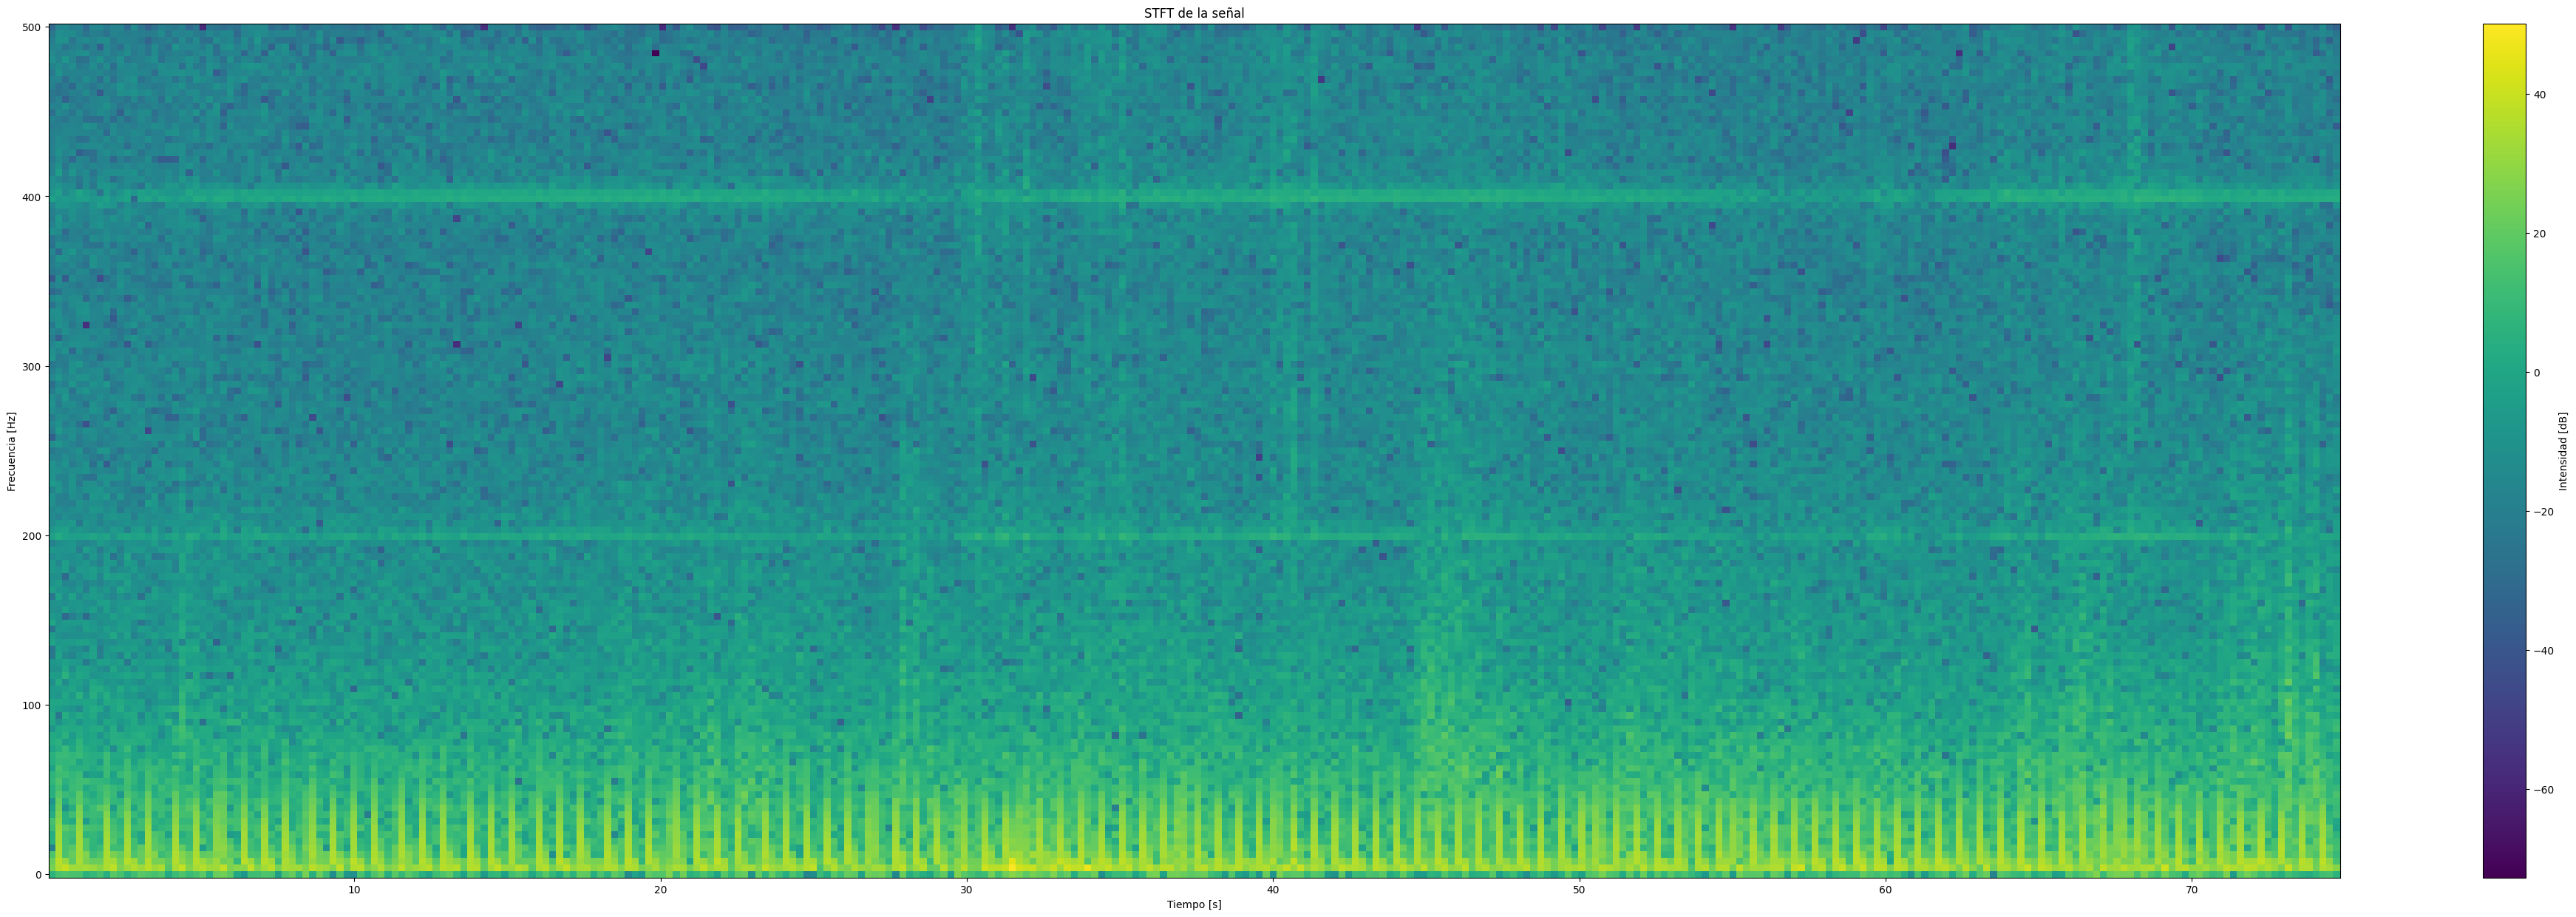

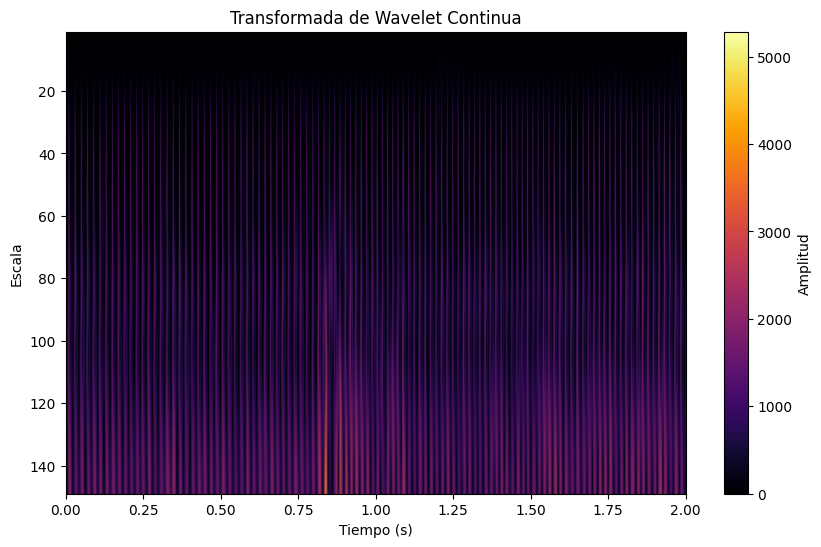

¿coinciden frecuencias?  True


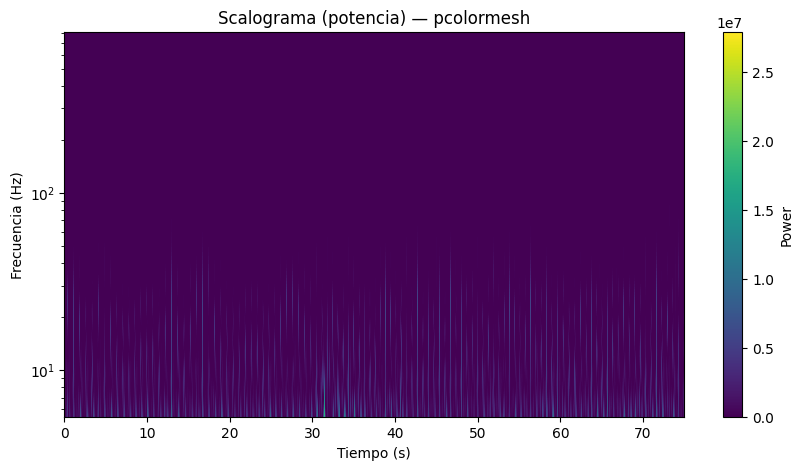

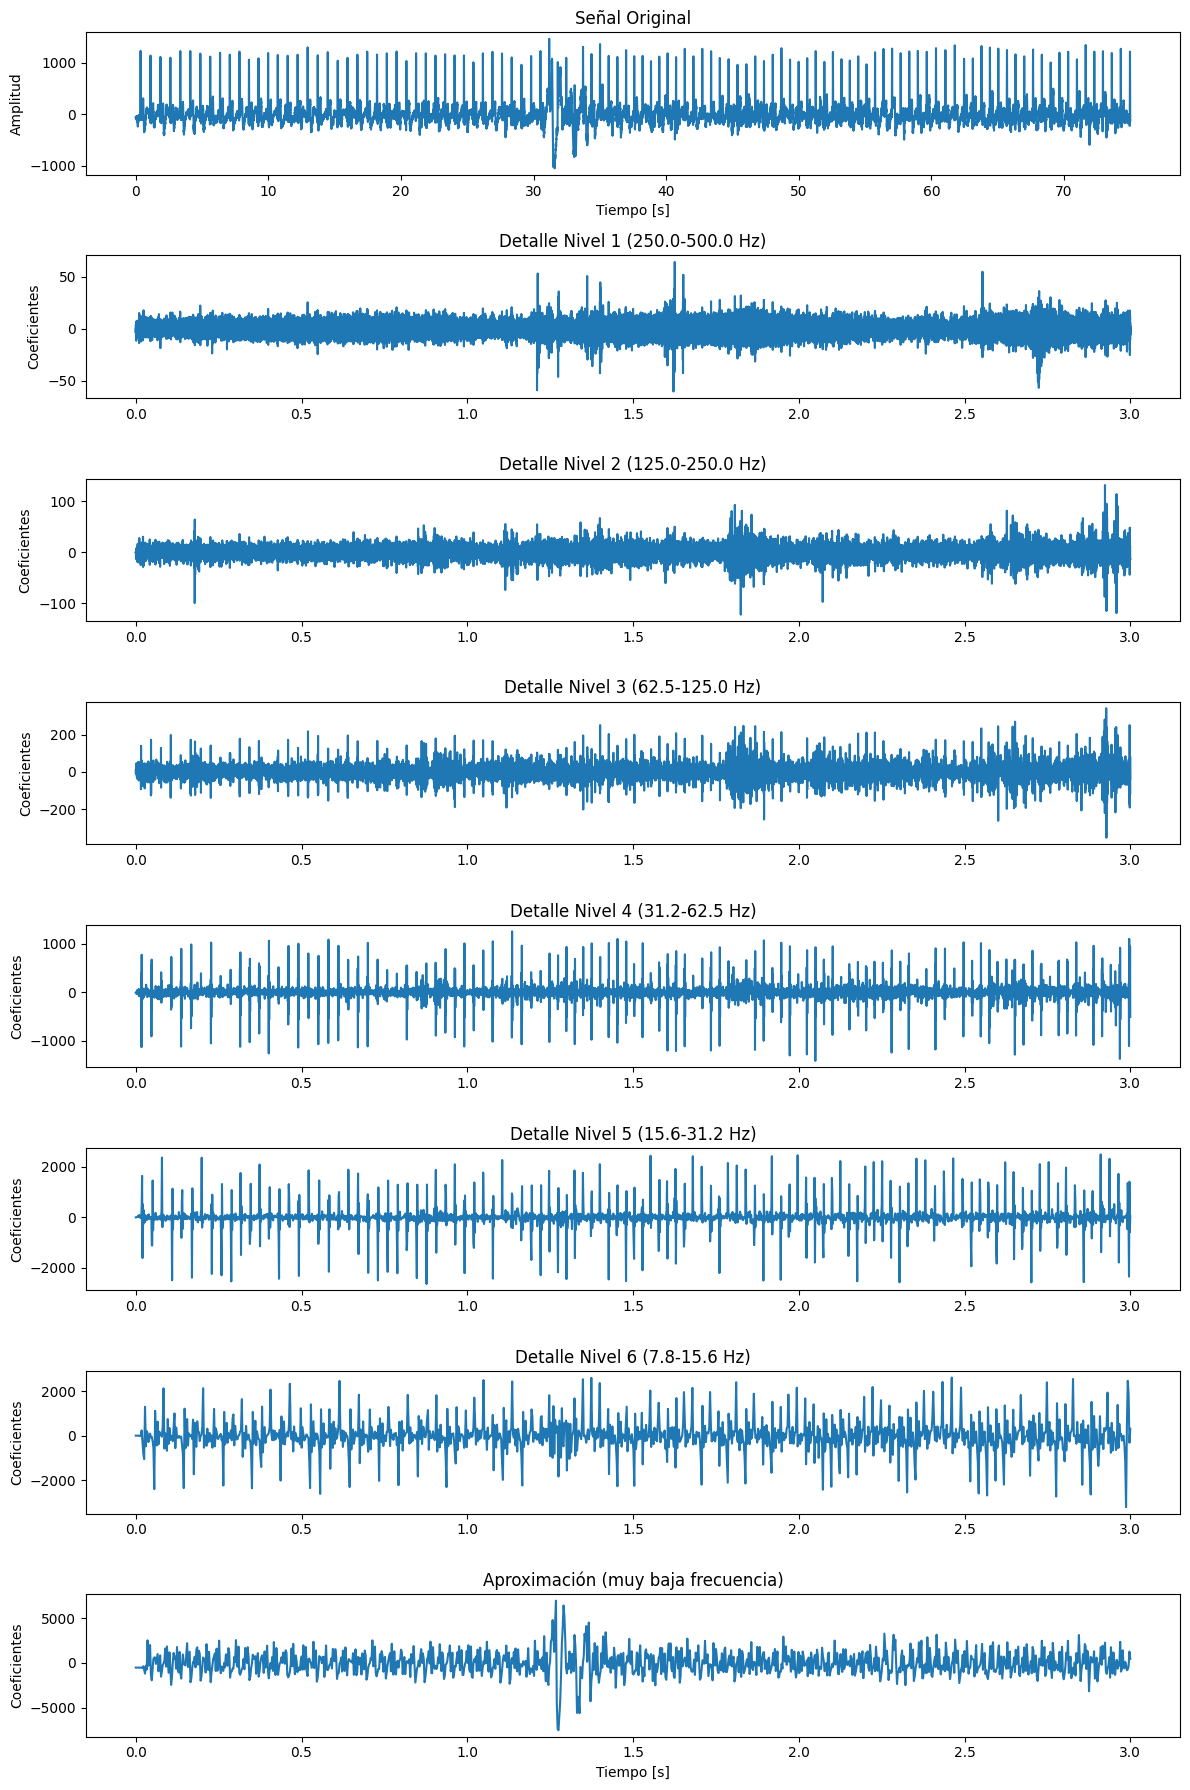

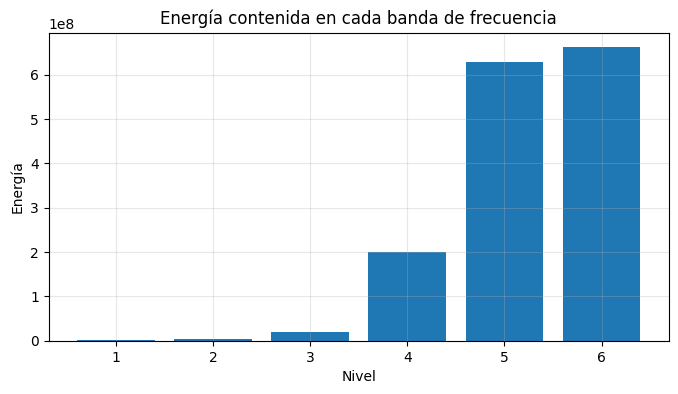

Nivel 1: 250.00 - 500.00 Hz | Energía = 1782653.62
Nivel 2: 125.00 - 250.00 Hz | Energía = 3258117.25
Nivel 3: 62.50 - 125.00 Hz | Energía = 18641274.00
Nivel 4: 31.25 - 62.50 Hz | Energía = 199848864.00
Nivel 5: 15.62 - 31.25 Hz | Energía = 628398464.00
Nivel 6: 7.81 - 15.62 Hz | Energía = 661816832.00


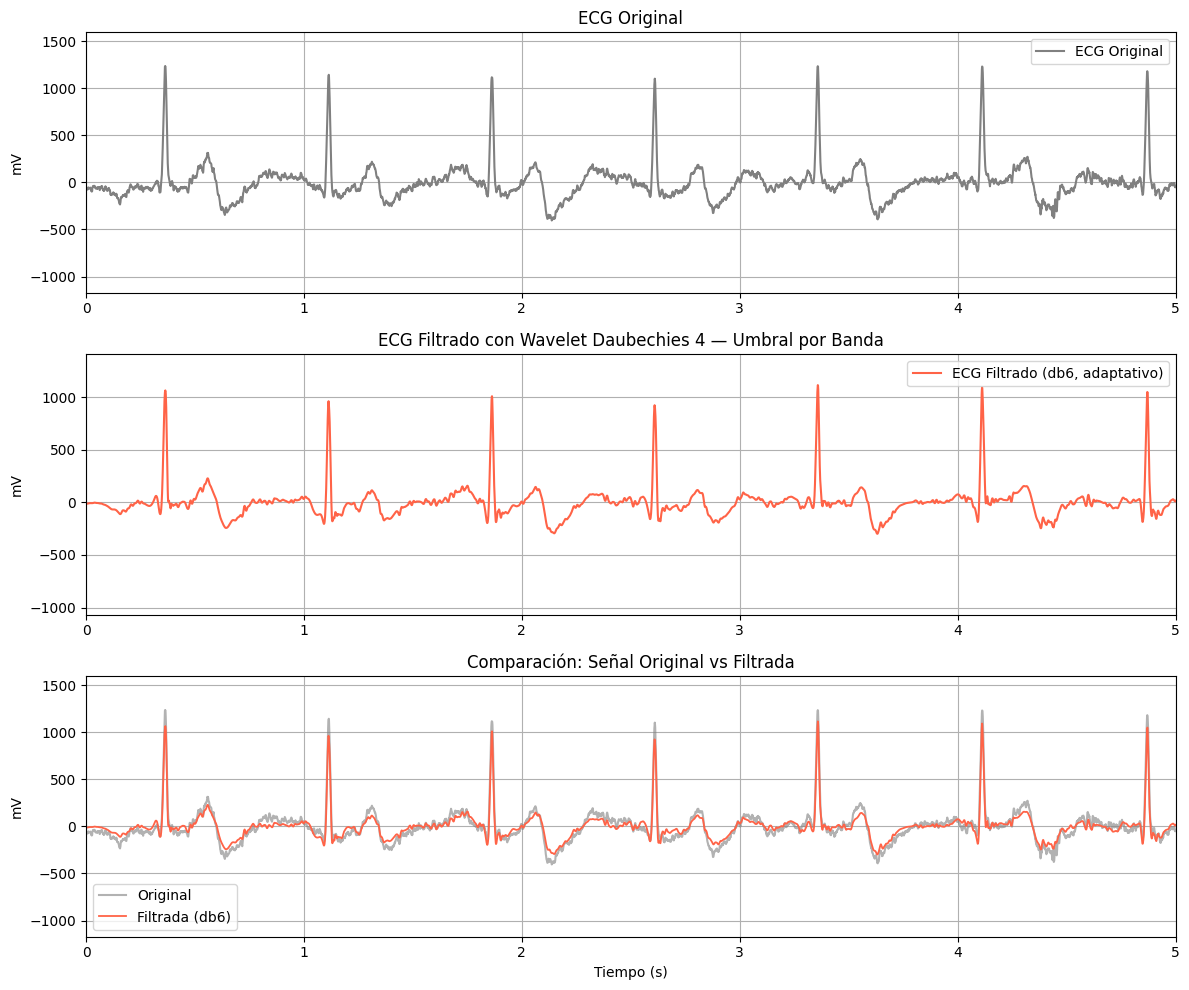

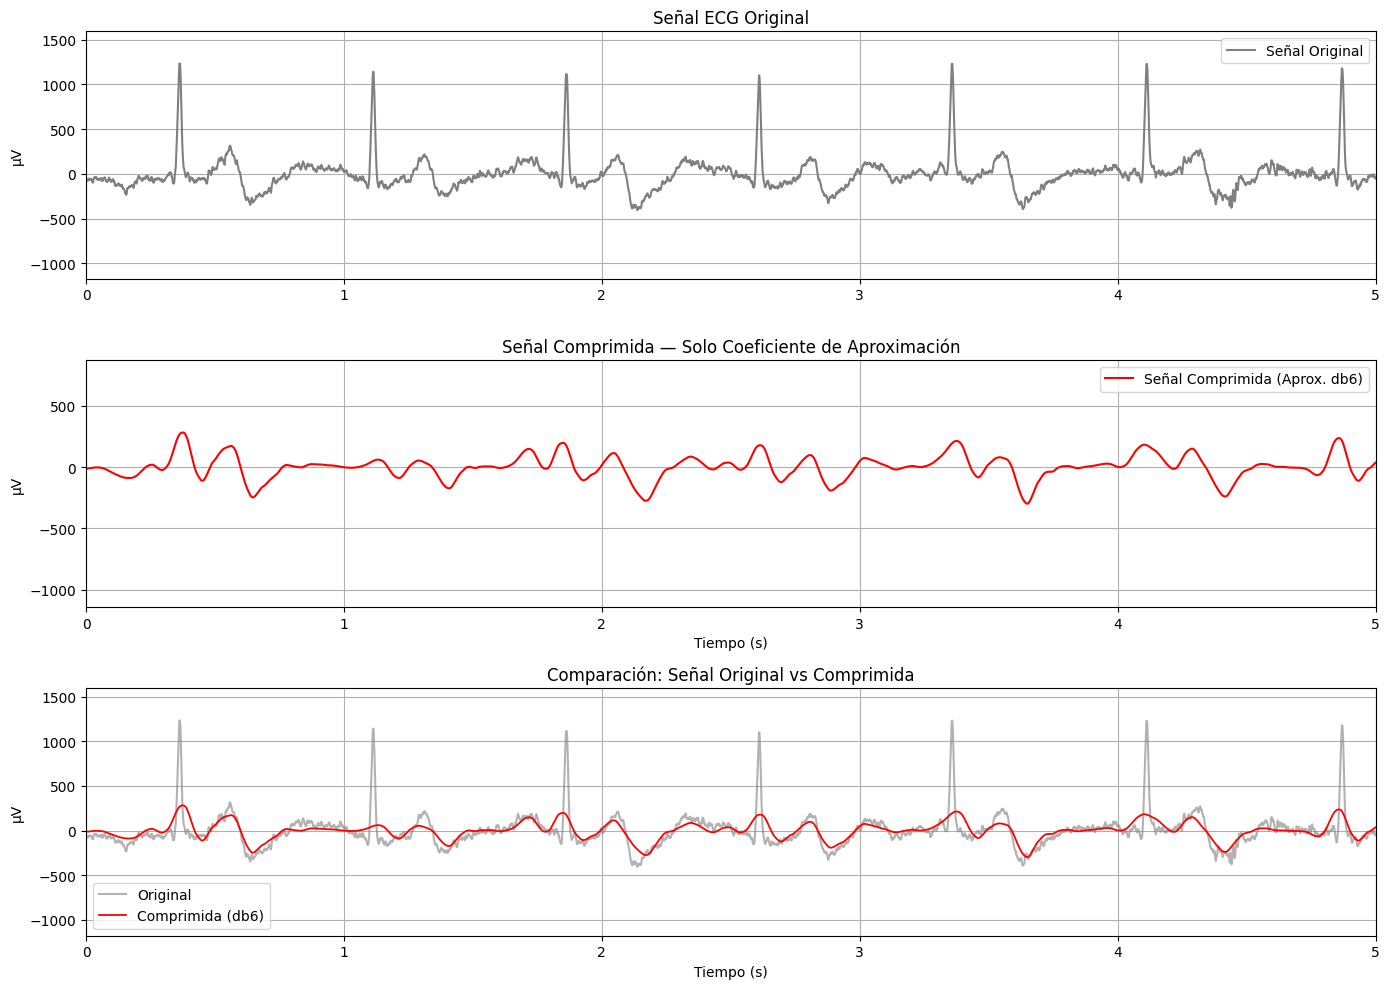

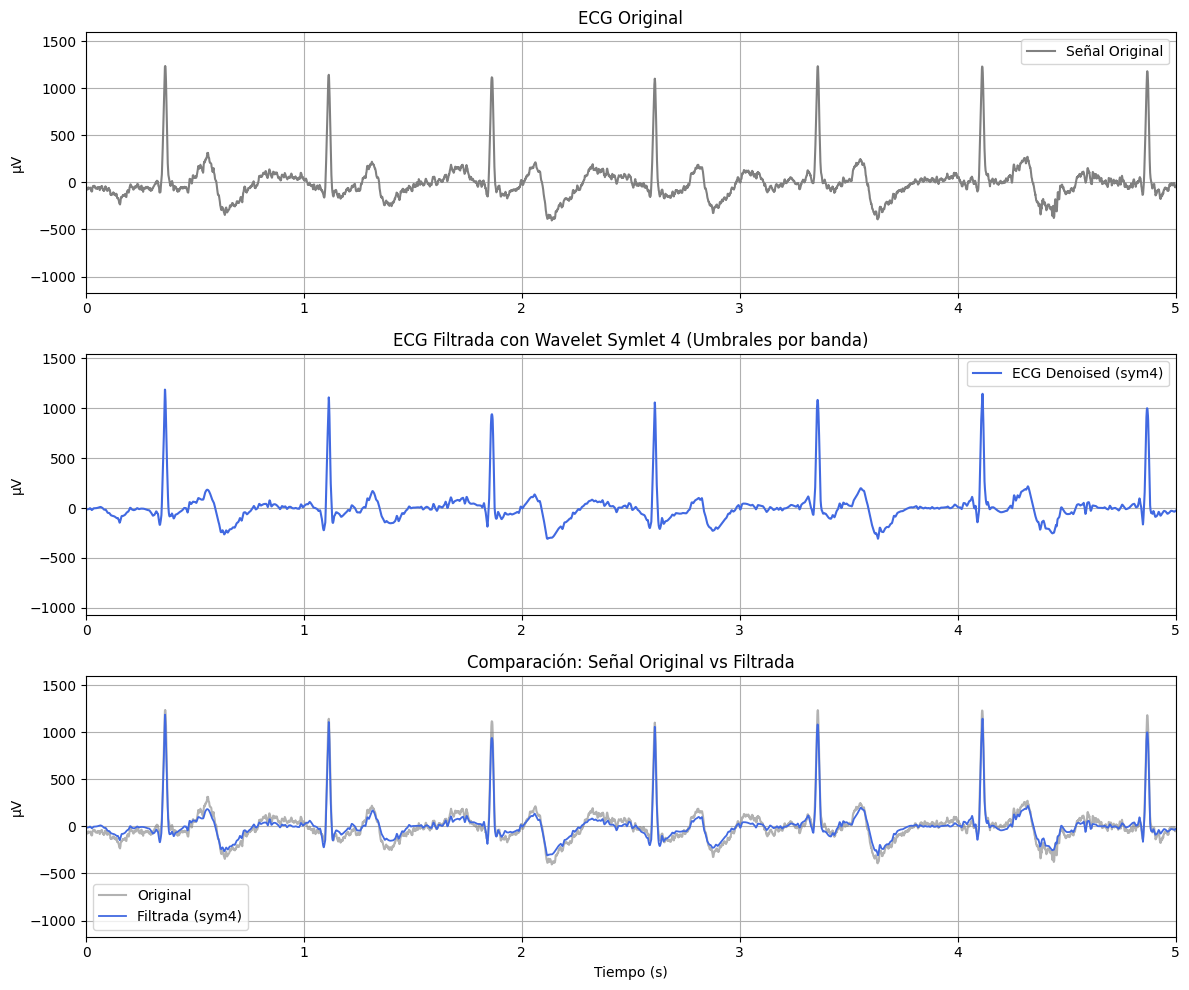

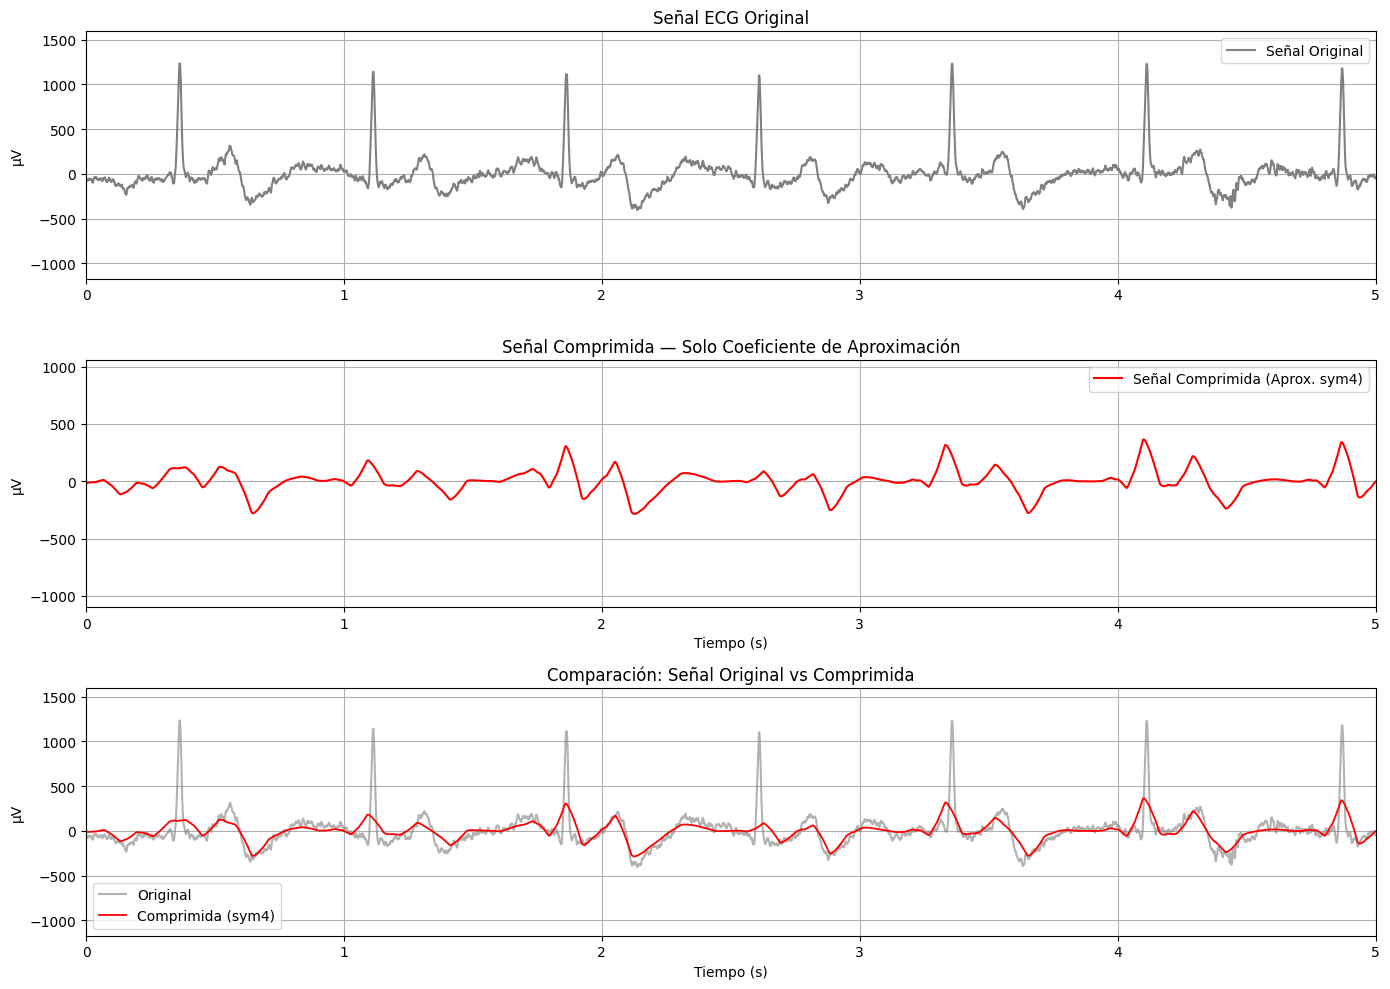

In [152]:


# --- Gráfico de la señal ECG ---
plt.figure(figsize=(12, 5))
plt.plot(t_2, y_2, label="Señal ECG")
plt.title("Apnea respiratoria - derivada 2", fontsize=14, fontweight='bold', loc='center')  # centrado correctamente
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (µV)")
plt.grid(linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# Calcular la DFT
X = np.fft.fft(y_2)

# Calcular las frecuencias correspondientes
frequencies = np.fft.fftfreq(len(y_2), 1/fs)

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(X))
plt.title('Espectro de frecuencias')
plt.xlabel('Frecuencia [Hz]')
plt.grid()

# Establecer límites en el eje x
plt.xlim([-100, 100])

plt.tight_layout()
plt.show()

# Calcular la STFT
f, t, Sxx = spectrogram(y_2, fs)
plt.figure(figsize=(50, 15))

# Visualizar el espectrograma
plt.pcolormesh(t, f, 10 * np.log10(Sxx))  # Usamos escala logarítmica para mejor visualización
plt.title('STFT de la señal')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.colorbar(label='Intensidad [dB]')
plt.show()

import pywt

# Definir la escala y la frecuencia central de la wavelet de Morlet
escala = np.arange(1, 150)

# Realizar la transformada de wavelet continua
coeficientes, frecuencias = pywt.cwt(y_2, escala, 'morl',sampling_period=1/1000)

# Graficar los coeficientes de la transformada de wavelet
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeficientes), extent=[0, 2, escala[-1], escala[0]], aspect='auto', cmap='inferno')
plt.colorbar(label='Amplitud')
plt.title('Transformada de Wavelet Continua')
plt.xlabel('Tiempo (s)')
plt.ylabel('Escala')
plt.show()


# verificación (opcional): calcular frecuencias con scale2frequency
freqs_check = pywt.scale2frequency('morl', escala) * fs
print("¿coinciden frecuencias? ", np.allclose(frecuencias, freqs_check))

# potencia (o magnitud), y normalización si quieres comparar escalas
power = np.abs(coeficientes)**2
# normalización común para comparar amplitudes entre escalas:
power_norm = power / np.sqrt(escala)[:, None]

# 1) Usando pcolormesh
plt.figure(figsize=(10,5))
plt.pcolormesh(t_2, frecuencias, power, shading='auto');
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.yscale('log')
plt.title('Scalograma (potencia) — pcolormesh')
plt.colorbar(label='Power')
plt.ylim(frecuencias.min(),frecuencias.max())
plt.show()

# ======================================
# PARTE 1: DWT
# ======================================
wavelet = 'db6'
niveles = 6
coeficientes = pywt.wavedec(y_2, wavelet, level=niveles)

# ======================================
# PARTE 2: Análisis de energía y bandas
# ======================================
# wavedec devuelve: [cA_n, cD_n, cD_{n-1}, ..., cD_1]
detalles = coeficientes[1:][::-1]  # invertimos el orden

energias = [np.sum(np.square(c)) for c in detalles]

# Bandas de frecuencia aproximadas para cada nivel
bandas = [(fs / (2 ** (i + 1)), fs / (2 ** i)) for i in range(1, niveles + 1)]

# ======================================
# PARTE 3: Gráficas
# ======================================
plt.figure(figsize=(12, 18))
plt.subplot(niveles + 2, 1, 1)
plt.plot(t_2, y_2)
plt.title('Señal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

# Graficar los niveles 1 → n (altas → bajas)
for i, c in enumerate(detalles, start=1):
    t_c = np.linspace(0, 3, len(c))  # eje temporal aproximado
    plt.subplot(niveles + 2, 1, i + 1)
    plt.plot(t_c, c)
    plt.title(f'Detalle Nivel {i} ({bandas[i-1][0]:.1f}-{bandas[i-1][1]:.1f} Hz)')
    plt.ylabel('Coeficientes')

# Aproximación final (muy baja frecuencia)
t_a = np.linspace(0, 3, len(coeficientes[0]))
plt.subplot(niveles + 2, 1, niveles + 2)
plt.plot(t_a, coeficientes[0])
plt.title('Aproximación (muy baja frecuencia)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Coeficientes')

plt.tight_layout()
plt.show()

# ======================================
# PARTE 4: Energía por nivel
# ======================================
plt.figure(figsize=(8, 4))
niveles_list = np.arange(1, niveles + 1)
plt.bar(niveles_list, energias)
plt.xlabel('Nivel')
plt.ylabel('Energía')
plt.title('Energía contenida en cada banda de frecuencia')
plt.xticks(niveles_list)
plt.grid(True, alpha=0.3)
plt.show()

# Mostrar tabla resumen
for i, (f_low, f_high) in enumerate(bandas):
    print(f"Nivel {i+1}: {f_low:.2f} - {f_high:.2f} Hz | Energía = {energias[i]:.2f}")

# --- Descomposición en wavelets ---
wavelet = 'db6'      # Wavelet más suave, buena para ECG
nivel = 6
coeffs = pywt.wavedec(y_2, wavelet, level=nivel)

# --- Frecuencia de muestreo ---
fs = 1000

# --- Calcular umbrales adaptativos ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))
        T *= 0.1
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

    else:
        # Detalles: ruido o componentes rápidas
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # En ECG, queremos conservar 0.5–40 Hz aprox
        if i == 1:      # D6 (~0–8 Hz)
            T *= 0.1   # Suavizar leve: respiración o línea base
        elif i == 2:    # D5 (~8–16 Hz)
            T *=0.1  # Mantener componentes útiles (onda T)
        elif i == 3:    # D4 (~16–32 Hz)
            T *=0.1  # Mantener QRS
        elif i == 4:    # D3 (~32–64 Hz)
            T *= 1.1  # Mantener QRS agudo
        elif i == 5:    # D2 (~64–128 Hz)
            T *= 1.8  # Ruido muscular o eléctrico
        elif i == 6:    # D1 (>128 Hz)
            T *= 2  # Filtrar agresivamente (ruido electromagnético
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

# --- Reconstrucción de la señal filtrada ---
senal_denoised = pywt.waverec(coeffs_umbral, wavelet)

# --- Gráficas ---
plt.figure(figsize=(12, 10))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(t_2, y_2, color='gray', label='ECG Original')
plt.title('ECG Original')
plt.ylabel('mV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# Señal filtrada
plt.subplot(3, 1, 2)
plt.plot(t_2, senal_denoised, color='tomato', label='ECG Filtrado (db6, adaptativo)')
plt.title('ECG Filtrado con Wavelet Daubechies 4 — Umbral por Banda')
plt.ylabel('mV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_2, y_2, color='gray', alpha=0.6, label='Original')
plt.plot(t_2, senal_denoised, color='tomato', linewidth=1.3, label='Filtrada (db6)')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlabel('Tiempo (s)')
plt.ylabel('mV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Obtener los coeficientes de aproximación
coef_aproximacion = coeffs_umbral[0]

coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion

# Reconstruir la señal comprimida
senal_comprimida = pywt.waverec(coeffs_zero, 'db6')

# Obtener el tiempo correspondiente a los datos
t_2_2 = np.linspace(0, len(y_2)/1000, len(senal_comprimida))


# --- Graficar ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_2, y_2, label='Señal Original', color='gray')
plt.title('Señal ECG Original')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_2_2, senal_comprimida, label='Señal Comprimida (Aprox. db6)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación')
plt.ylabel('µV')
plt.xlim(0,5)
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_2, y_2, color='gray', alpha=0.6, label='Original')
plt.plot(t_2_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (db6)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# --- Descomposición wavelet ---
coeffs = pywt.wavedec(y_2, 'sym4', level=6)

# --- Calcular umbrales adaptativos ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))
        T *= 0.1
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

    else:
        # Detalles: ruido o componentes rápidas
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # En ECG, queremos conservar 0.5–40 Hz aprox
        if i == 1:      # D6 (~0–8 Hz)
            T *= 0.1   # Suavizar leve: respiración o línea base
        elif i == 2:    # D5 (~8–16 Hz)
            T *=0.1  # Mantener componentes útiles (onda T)
        elif i == 3:    # D4 (~16–32 Hz)
            T *=0.1  # Mantener QRS
        elif i == 4:    # D3 (~32–64 Hz)
            T *= 1.1  # Mantener QRS agudo
        elif i == 5:    # D2 (~64–128 Hz)
            T *= 1.8  # Ruido muscular o eléctrico
        elif i == 6:    # D1 (>128 Hz)
            T *= 2   # Filtrar agresivamente (ruido electromagnético
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))


# --- Reconstrucción ---
senal_denoised = pywt.waverec(coeffs_umbral, 'sym4')
senal_denoised = senal_denoised[:len(y_2)]  # ajustar tamaño

# --- Gráficas ---
plt.figure(figsize=(12, 10))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(t_2, y_2, color='gray', label='Señal Original')
plt.title('ECG Original')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# Señal denoised
plt.subplot(3, 1, 2)
plt.plot(t_2, senal_denoised, color='royalblue', label='ECG Denoised (sym4)')
plt.title('ECG Filtrada con Wavelet Symlet 4 (Umbrales por banda)')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_2, y_2, color='gray', alpha=0.6, label='Original')
plt.plot(t_2, senal_denoised, color='royalblue', linewidth=1.3, label='Filtrada (sym4)')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlabel('Tiempo (s)')
plt.xlim(0,5)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Obtener los coeficientes de aproximación
coef_aproximacion = coeffs_umbral[0]

coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion

# Reconstruir la señal comprimida
senal_comprimida = pywt.waverec(coeffs_zero, 'sym4')

# Obtener el tiempo correspondiente a los datos
t_2_2 = np.linspace(0, len(y_2)/1000, len(senal_comprimida))


# --- Graficar ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_2, y_2, label='Señal Original', color='gray')
plt.title('Señal ECG Original')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_2_2, senal_comprimida, label='Señal Comprimida (Aprox. sym4)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación')
plt.ylabel('µV')
plt.xlim(0,5)
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_2, y_2, color='gray', alpha=0.6, label='Original')
plt.plot(t_2_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (sym4)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## C) Análisis para señal: Post ejercicio - derivada 2

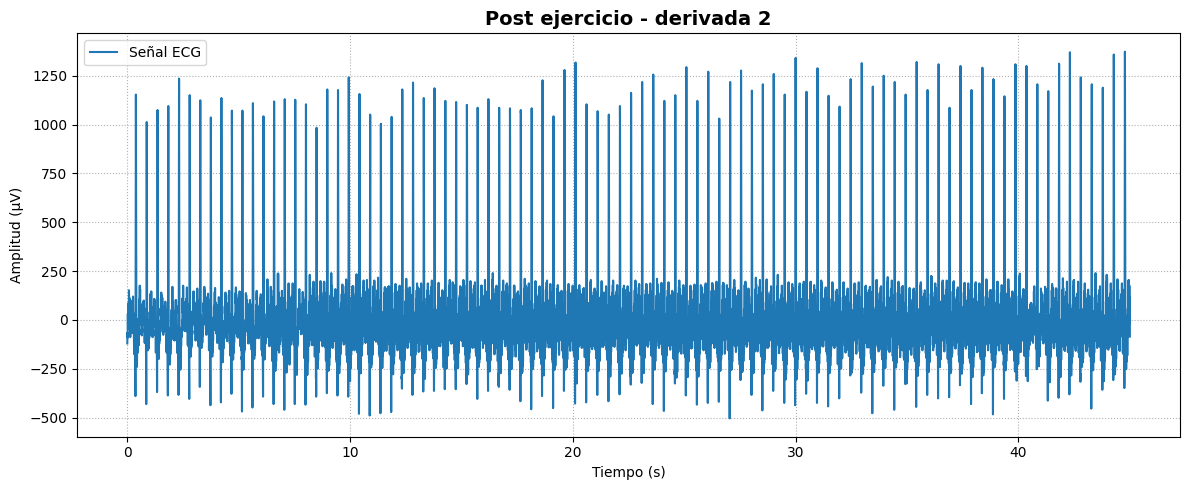

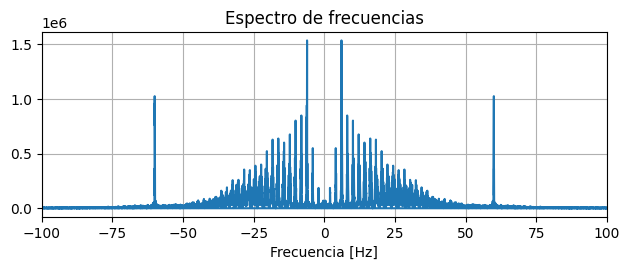

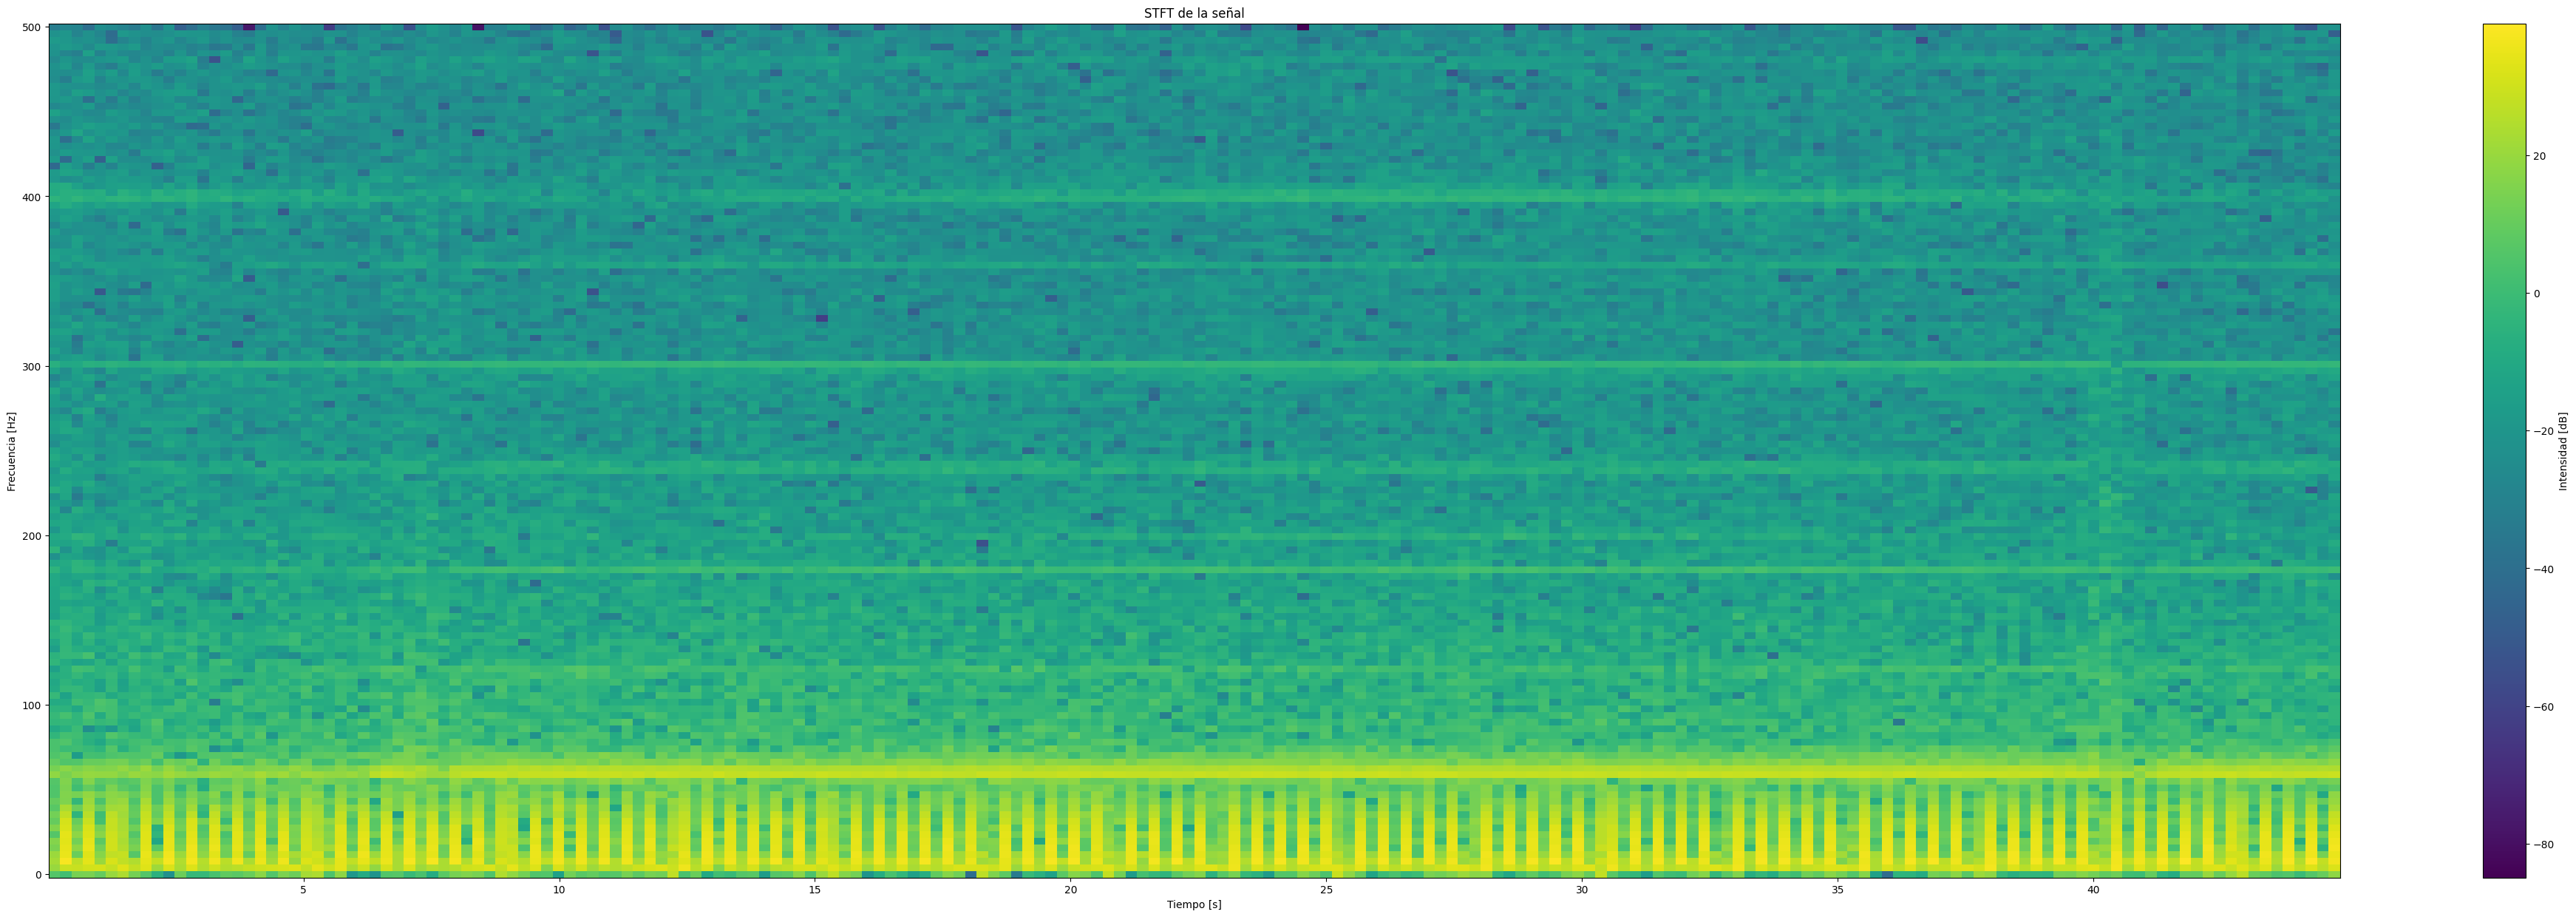

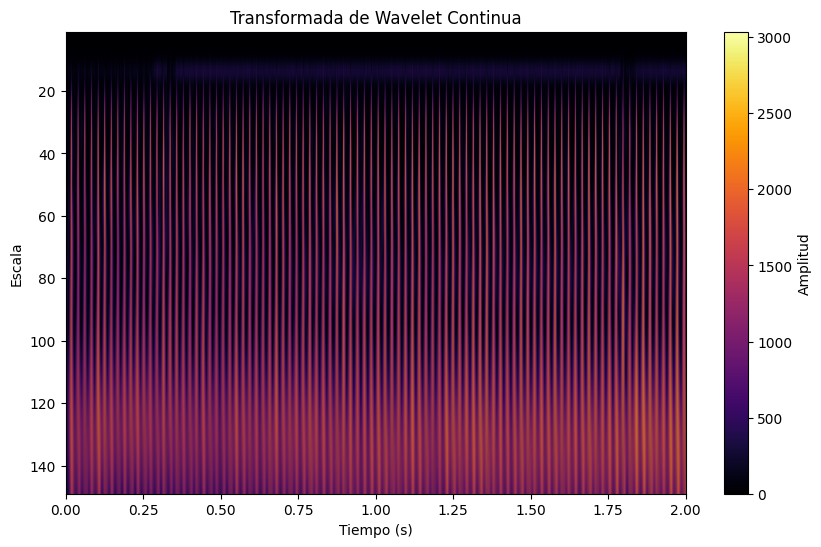

¿coinciden frecuencias?  True


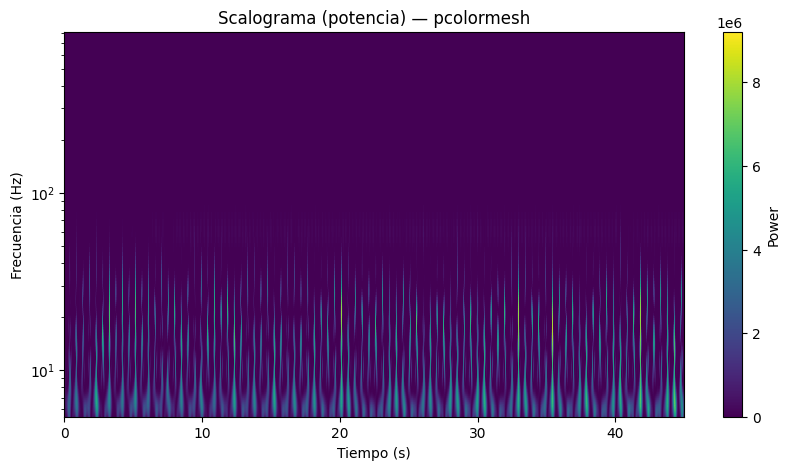

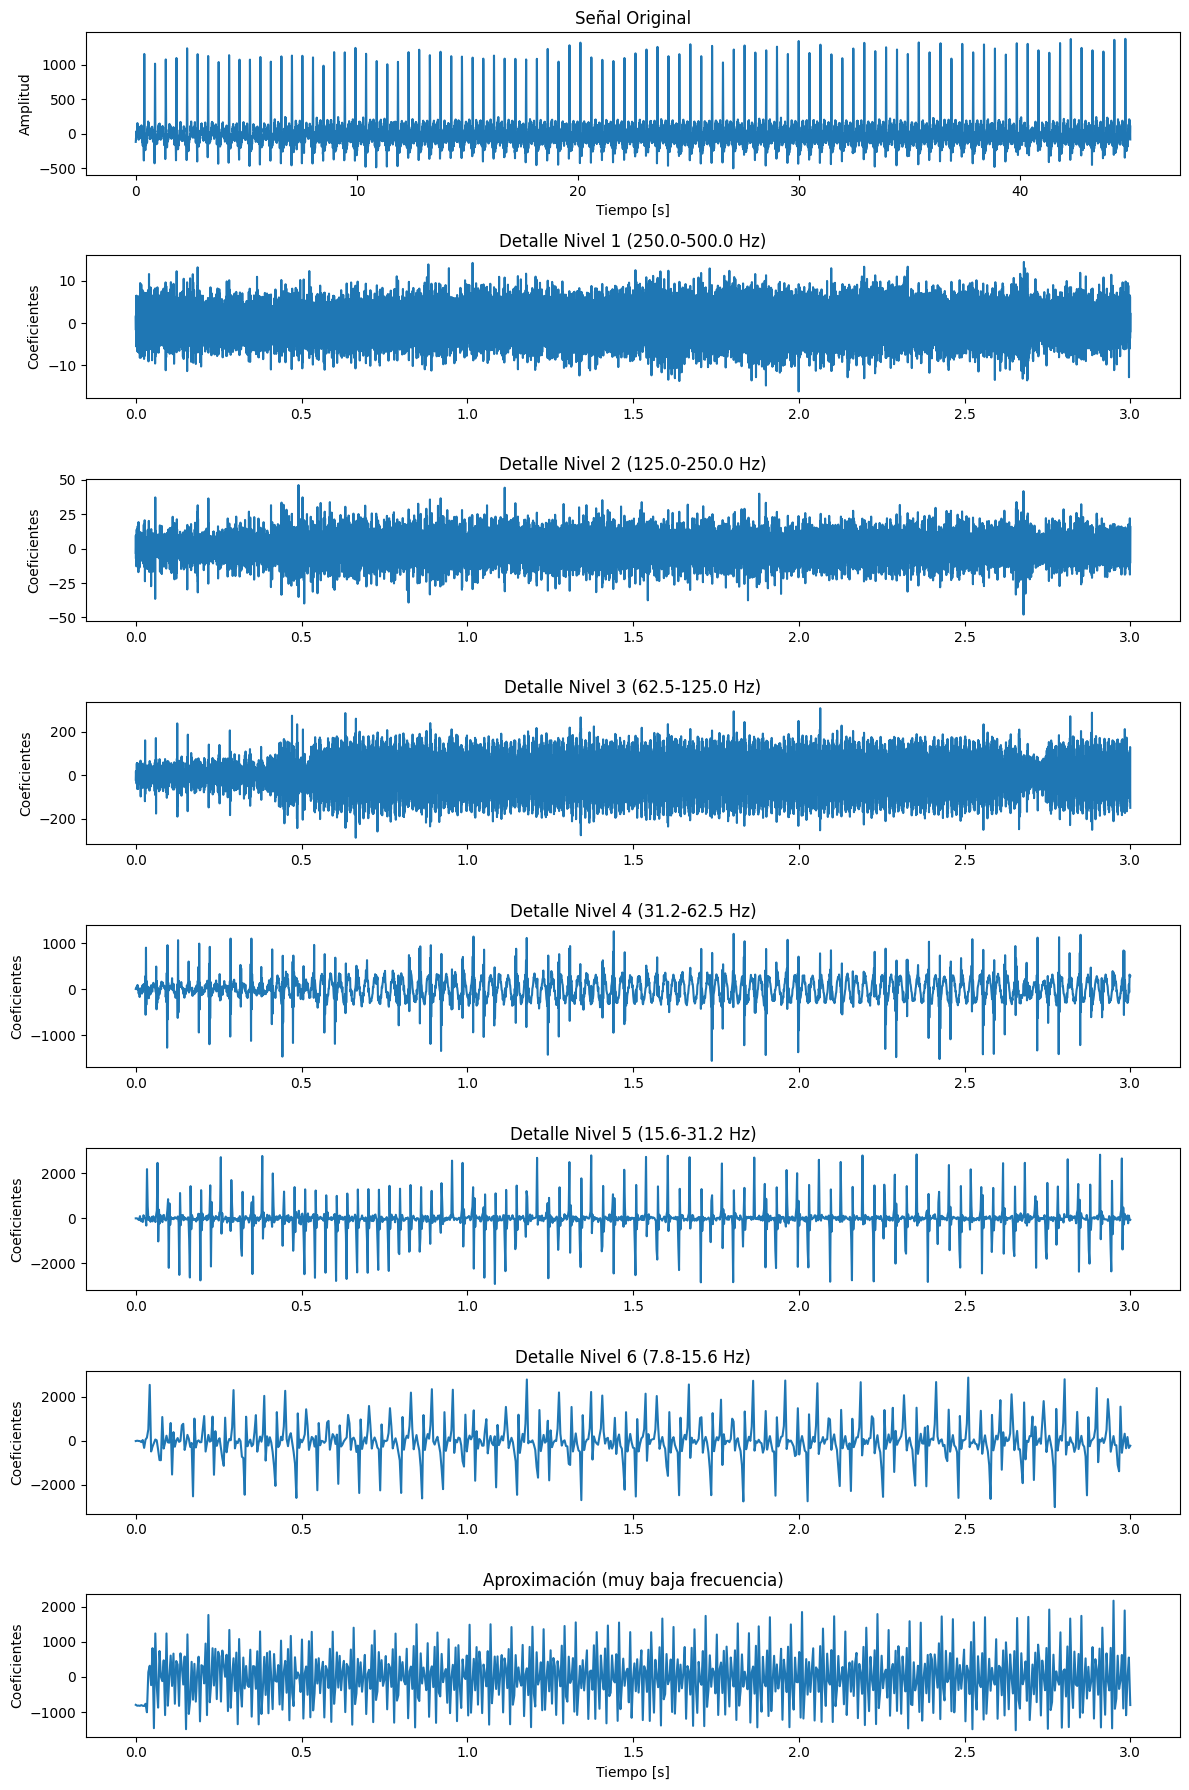

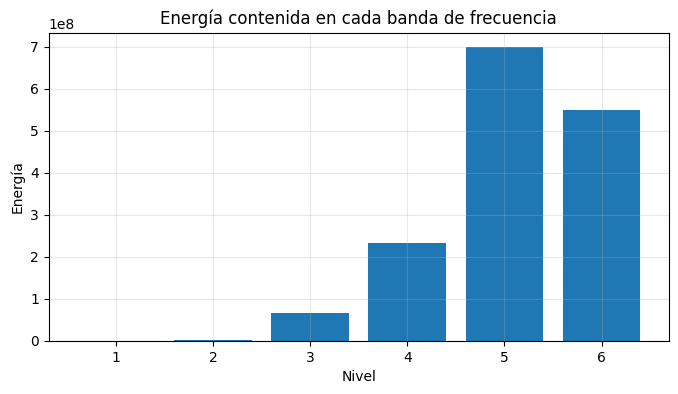

Nivel 1: 250.00 - 500.00 Hz | Energía = 319932.81
Nivel 2: 125.00 - 250.00 Hz | Energía = 1126292.50
Nivel 3: 62.50 - 125.00 Hz | Energía = 65919672.00
Nivel 4: 31.25 - 62.50 Hz | Energía = 232433952.00
Nivel 5: 15.62 - 31.25 Hz | Energía = 698245760.00
Nivel 6: 7.81 - 15.62 Hz | Energía = 548556544.00


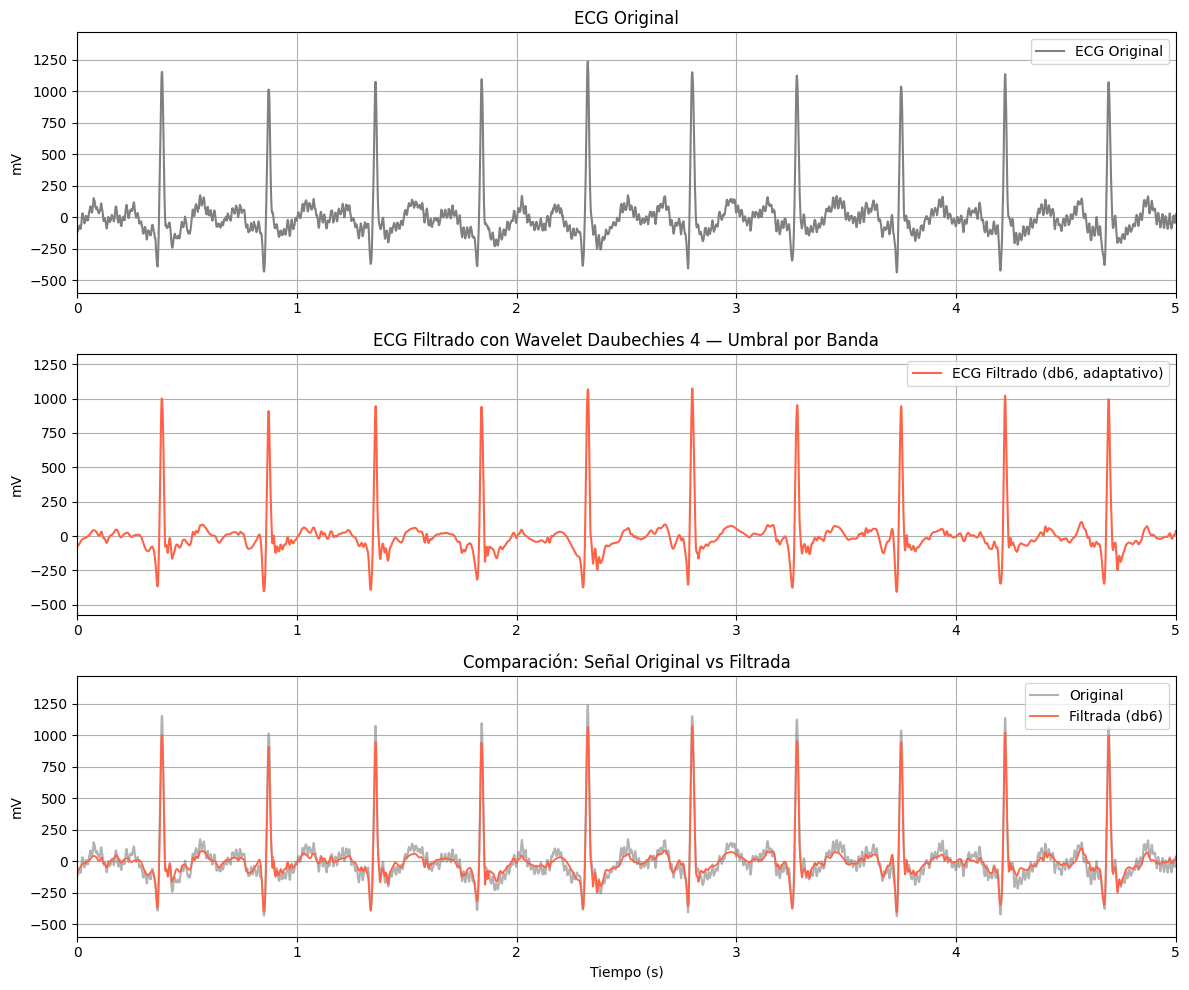

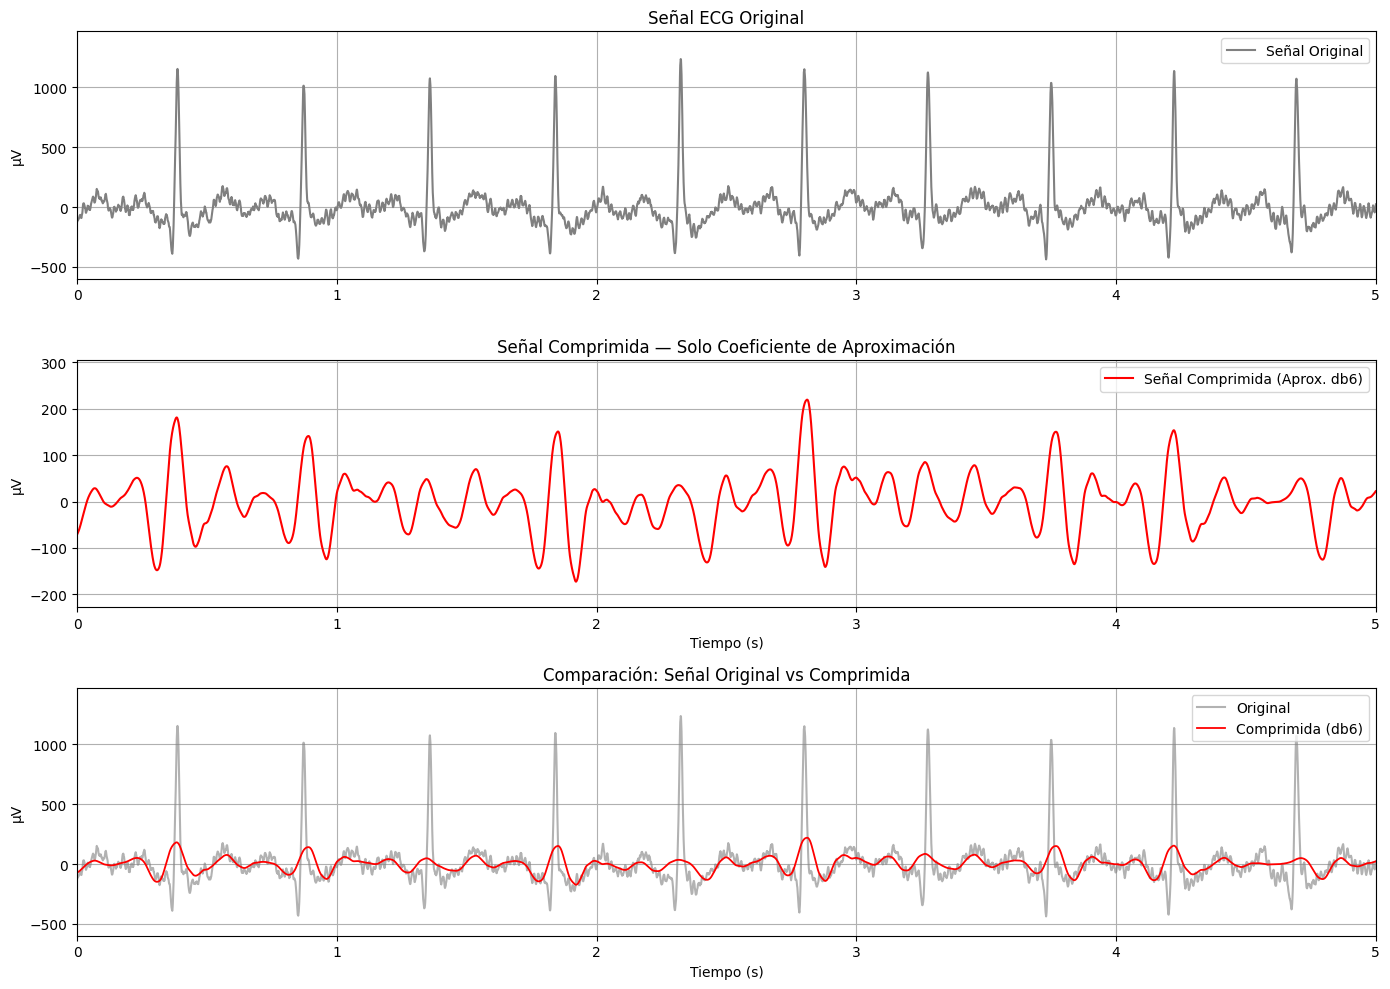

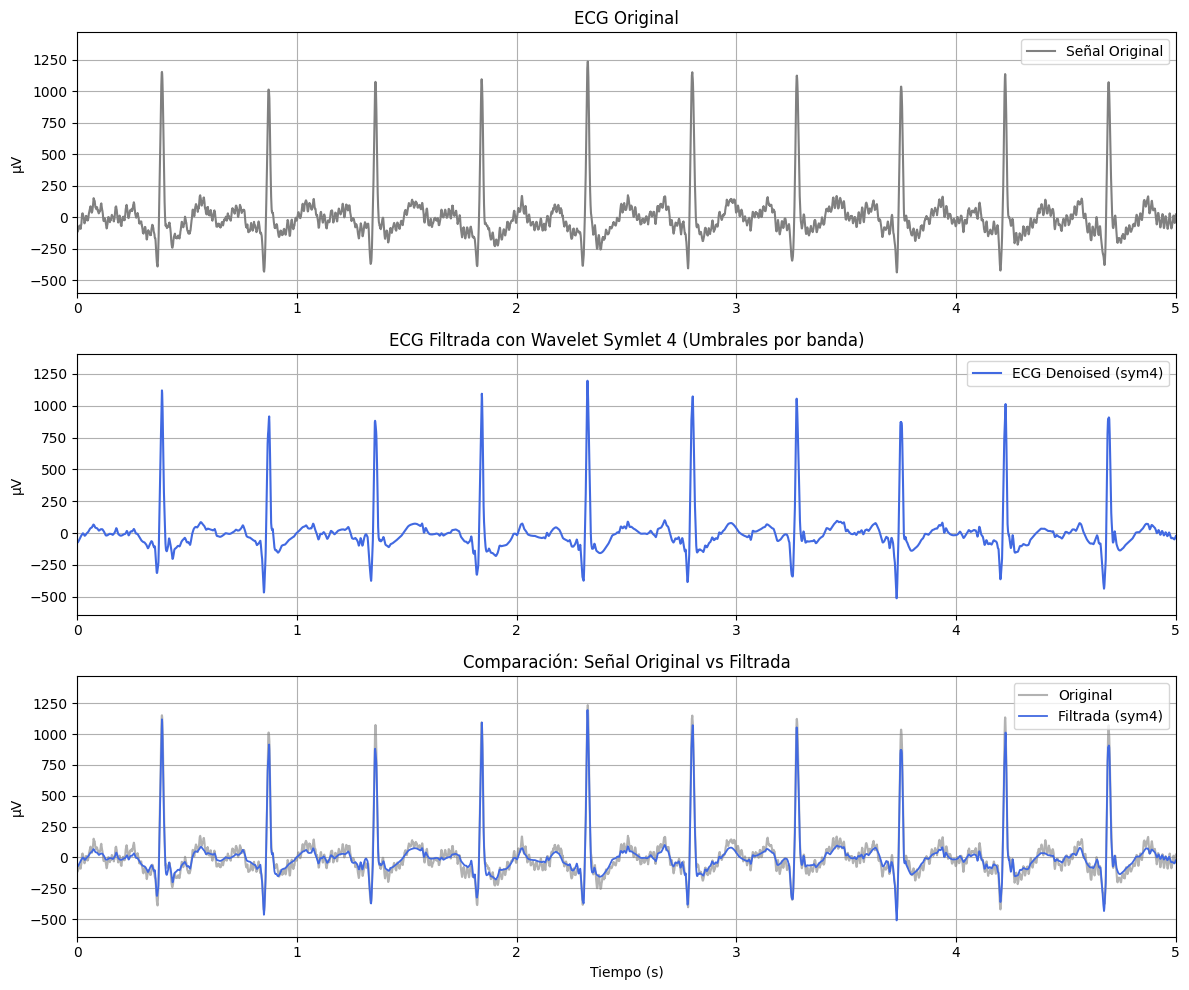

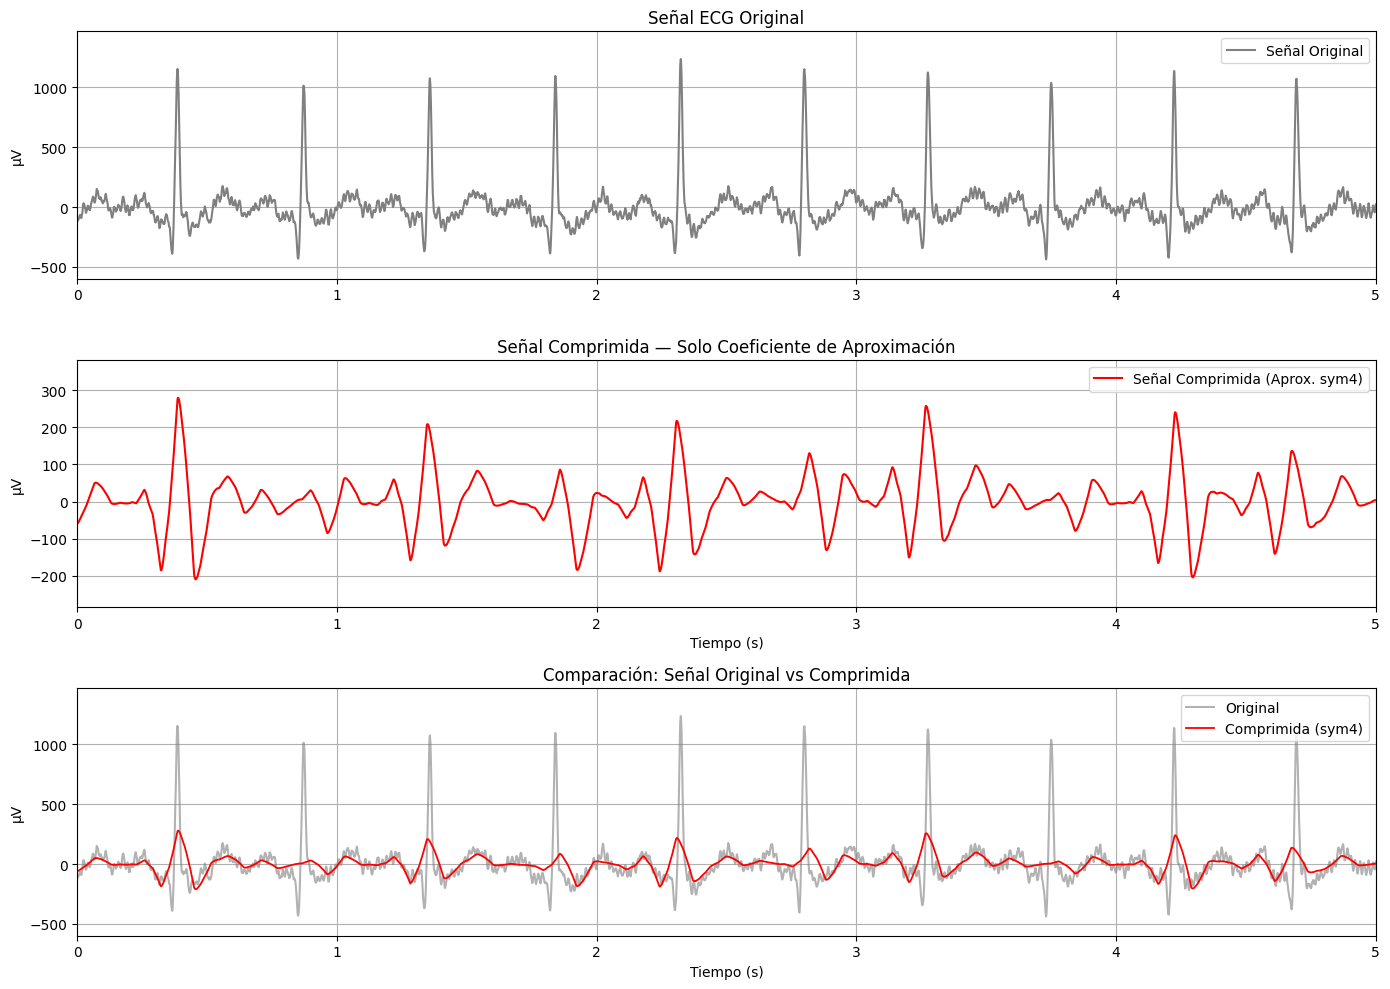

In [153]:
# --- Gráfico de la señal ECG ---
plt.figure(figsize=(12, 5))
plt.plot(t_3, y_3, label="Señal ECG")
plt.title("Post ejercicio - derivada 2", fontsize=14, fontweight='bold', loc='center')  # centrado correctamente
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (µV)")
plt.grid(linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# Calcular la DFT
X = np.fft.fft(y_3)

# Calcular las frecuencias correspondientes
frequencies = np.fft.fftfreq(len(y_3), 1/fs)

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(X))
plt.title('Espectro de frecuencias')
plt.xlabel('Frecuencia [Hz]')
plt.grid()

# Establecer límites en el eje x
plt.xlim([-100, 100])

plt.tight_layout()
plt.show()

# Calcular la STFT
f, t, Sxx = spectrogram(y_3, fs)
plt.figure(figsize=(50, 15))

# Visualizar el espectrograma
plt.pcolormesh(t, f, 10 * np.log10(Sxx))  # Usamos escala logarítmica para mejor visualización
plt.title('STFT de la señal')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.colorbar(label='Intensidad [dB]')
plt.show()

import pywt

# Definir la escala y la frecuencia central de la wavelet de Morlet
escala = np.arange(1, 150)

# Realizar la transformada de wavelet continua
coeficientes, frecuencias = pywt.cwt(y_3, escala, 'morl',sampling_period=1/1000)

# Graficar los coeficientes de la transformada de wavelet
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeficientes), extent=[0, 2, escala[-1], escala[0]], aspect='auto', cmap='inferno')
plt.colorbar(label='Amplitud')
plt.title('Transformada de Wavelet Continua')
plt.xlabel('Tiempo (s)')
plt.ylabel('Escala')
plt.show()


# verificación (opcional): calcular frecuencias con scale2frequency
freqs_check = pywt.scale2frequency('morl', escala) * fs
print("¿coinciden frecuencias? ", np.allclose(frecuencias, freqs_check))

# potencia (o magnitud), y normalización si quieres comparar escalas
power = np.abs(coeficientes)**2
# normalización común para comparar amplitudes entre escalas:
power_norm = power / np.sqrt(escala)[:, None]

# 1) Usando pcolormesh
plt.figure(figsize=(10,5))
plt.pcolormesh(t_3, frecuencias, power, shading='auto');
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.yscale('log')
plt.title('Scalograma (potencia) — pcolormesh')
plt.colorbar(label='Power')
plt.ylim(frecuencias.min(),frecuencias.max())
plt.show()

# ======================================
# PARTE 1: DWT
# ======================================
wavelet = 'db6'
niveles = 6
coeficientes = pywt.wavedec(y_3, wavelet, level=niveles)

# ======================================
# PARTE 2: Análisis de energía y bandas
# ======================================
# wavedec devuelve: [cA_n, cD_n, cD_{n-1}, ..., cD_1]
detalles = coeficientes[1:][::-1]  # invertimos el orden

energias = [np.sum(np.square(c)) for c in detalles]

# Bandas de frecuencia aproximadas para cada nivel
bandas = [(fs / (2 ** (i + 1)), fs / (2 ** i)) for i in range(1, niveles + 1)]

# ======================================
# PARTE 3: Gráficas
# ======================================
plt.figure(figsize=(12, 18))
plt.subplot(niveles + 2, 1, 1)
plt.plot(t_3, y_3)
plt.title('Señal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

# Graficar los niveles 1 → n (altas → bajas)
for i, c in enumerate(detalles, start=1):
    t_c = np.linspace(0, 3, len(c))  # eje temporal aproximado
    plt.subplot(niveles + 2, 1, i + 1)
    plt.plot(t_c, c)
    plt.title(f'Detalle Nivel {i} ({bandas[i-1][0]:.1f}-{bandas[i-1][1]:.1f} Hz)')
    plt.ylabel('Coeficientes')

# Aproximación final (muy baja frecuencia)
t_a = np.linspace(0, 3, len(coeficientes[0]))
plt.subplot(niveles + 2, 1, niveles + 2)
plt.plot(t_a, coeficientes[0])
plt.title('Aproximación (muy baja frecuencia)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Coeficientes')

plt.tight_layout()
plt.show()

# ======================================
# PARTE 4: Energía por nivel
# ======================================
plt.figure(figsize=(8, 4))
niveles_list = np.arange(1, niveles + 1)
plt.bar(niveles_list, energias)
plt.xlabel('Nivel')
plt.ylabel('Energía')
plt.title('Energía contenida en cada banda de frecuencia')
plt.xticks(niveles_list)
plt.grid(True, alpha=0.3)
plt.show()

# Mostrar tabla resumen
for i, (f_low, f_high) in enumerate(bandas):
    print(f"Nivel {i+1}: {f_low:.2f} - {f_high:.2f} Hz | Energía = {energias[i]:.2f}")

# --- Descomposición en wavelets ---
wavelet = 'db6'      # Wavelet más suave, buena para ECG
nivel = 6
coeffs = pywt.wavedec(y_3, wavelet, level=nivel)

# --- Frecuencia de muestreo ---
fs = 1000

# --- Calcular umbrales adaptativos ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))
        T *= 0.1
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

    else:
        # Detalles: ruido o componentes rápidas
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # En ECG, queremos conservar 0.5–40 Hz aprox
        if i == 1:      # D6 (~0–8 Hz)
            T *= 0.1   # Suavizar leve: respiración o línea base
        elif i == 2:    # D5 (~8–16 Hz)
            T *=0.1  # Mantener componentes útiles (onda T)
        elif i == 3:    # D4 (~16–32 Hz)
            T *=0.1  # Mantener QRS
        elif i == 4:    # D3 (~32–64 Hz)
            T *= 1.1  # Mantener QRS agudo
        elif i == 5:    # D2 (~64–128 Hz)
            T *= 1.8  # Ruido muscular o eléctrico
        elif i == 6:    # D1 (>128 Hz)
            T *= 2   # Filtrar agresivamente (ruido electromagnético
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

# --- Reconstrucción de la señal filtrada ---
senal_denoised = pywt.waverec(coeffs_umbral, wavelet)

# --- Gráficas ---
plt.figure(figsize=(12, 10))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(t_3, y_3, color='gray', label='ECG Original')
plt.title('ECG Original')
plt.ylabel('mV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# Señal filtrada
plt.subplot(3, 1, 2)
plt.plot(t_3, senal_denoised, color='tomato', label='ECG Filtrado (db6, adaptativo)')
plt.title('ECG Filtrado con Wavelet Daubechies 4 — Umbral por Banda')
plt.ylabel('mV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_3, y_3, color='gray', alpha=0.6, label='Original')
plt.plot(t_3, senal_denoised, color='tomato', linewidth=1.3, label='Filtrada (db6)')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlabel('Tiempo (s)')
plt.ylabel('mV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Obtener los coeficientes de aproximación
coef_aproximacion = coeffs_umbral[0]

coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion

# Reconstruir la señal comprimida
senal_comprimida = pywt.waverec(coeffs_zero, 'db6')

# Obtener el tiempo correspondiente a los datos
t_3_2 = np.linspace(0, len(y_3)/1000, len(senal_comprimida))


# --- Graficar ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_3, y_3, label='Señal Original', color='gray')
plt.title('Señal ECG Original')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_3_2, senal_comprimida, label='Señal Comprimida (Aprox. db6)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación')
plt.ylabel('µV')
plt.xlim(0,5)
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_3, y_3, color='gray', alpha=0.6, label='Original')
plt.plot(t_3_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (db6)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# --- Descomposición wavelet ---
coeffs = pywt.wavedec(y_3, 'sym4', level=6)

# Mantener la aproximación (bajas frecuencias)
# --- Calcular umbrales adaptativos ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))
        T *= 0.1
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

    else:
        # Detalles: ruido o componentes rápidas
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # En ECG, queremos conservar 0.5–40 Hz aprox
        if i == 1:      # D6 (~0–8 Hz)
            T *= 0.1   # Suavizar leve: respiración o línea base
        elif i == 2:    # D5 (~8–16 Hz)
            T *=0.1  # Mantener componentes útiles (onda T)
        elif i == 3:    # D4 (~16–32 Hz)
            T *=0.1  # Mantener QRS
        elif i == 4:    # D3 (~32–64 Hz)
            T *= 1.1  # Mantener QRS agudo
        elif i == 5:    # D2 (~64–128 Hz)
            T *= 1.8  # Ruido muscular o eléctrico
        elif i == 6:    # D1 (>128 Hz)
            T *= 2   # Filtrar agresivamente (ruido electromagnético
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

# --- Reconstrucción ---
senal_denoised = pywt.waverec(coeffs_umbral, 'sym4')
senal_denoised = senal_denoised[:len(y_3)]  # ajustar tamaño

# --- Gráficas ---
plt.figure(figsize=(12, 10))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(t_3, y_3, color='gray', label='Señal Original')
plt.title('ECG Original')
plt.xlim(0,5)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# Señal denoised
plt.subplot(3, 1, 2)
plt.plot(t_3, senal_denoised, color='royalblue', label='ECG Denoised (sym4)')
plt.title('ECG Filtrada con Wavelet Symlet 4 (Umbrales por banda)')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()
plt.grid(True)
plt.legend()

# Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_3, y_3, color='gray', alpha=0.6, label='Original')
plt.plot(t_3, senal_denoised, color='royalblue', linewidth=1.3, label='Filtrada (sym4)')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Obtener los coeficientes de aproximación
coef_aproximacion = coeffs_umbral[0]

coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion

# Reconstruir la señal comprimida
senal_comprimida = pywt.waverec(coeffs_zero, 'sym4')

# Obtener el tiempo correspondiente a los datos
t_3_2 = np.linspace(0, len(y_3)/1000, len(senal_comprimida))


# --- Graficar ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_3, y_3, label='Señal Original', color='gray')
plt.title('Señal ECG Original')
plt.ylabel('µV')
plt.xlim(0,5)
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_3_2, senal_comprimida, label='Señal Comprimida (Aprox. sym4)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación')
plt.ylabel('µV')
plt.xlim(0,5)
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_3, y_3, color='gray', alpha=0.6, label='Original')
plt.plot(t_3_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (sym4)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.xlim(0,5)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()